# Introduction

The goal of this competition is to **predict MDS-UPDR scores**, which measure progression **in patients with Parkinson's disease**. The Movement Disorder Society-Sponsored Revision of the Unified Parkinson's Disease Rating Scale (MDS-UPDRS) is a comprehensive assessment of both motor and non-motor symptoms associated with Parkinson's. We will **develop a model trained on data of protein and peptide levels over time** in subjects with Parkinson’s disease versus normal age-matched control subjects.

# Import Libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Define Metric SMAPE

This is a Python function that calculates **the symmetric mean absolute percentage error (SMAPE) between two arrays, y_true and y_pred**.

The SMAPE is a measure of the percentage difference between two values, and it is commonly used to evaluate the accuracy of forecasts or predictions. The formula for SMAPE is:

\begin{equation*}
\text{SMAPE}(y_{\text{true}}, y_{\text{pred}}) = \frac{100}{n} \sum_{i=1}^{n} 
\begin{cases}
\dfrac{2 \cdot \left| y_{\text{pred}, i} - y_{\text{true}, i} \right|}{\left| y_{\text{pred}, i} \right| + \left| y_{\text{true}, i} \right|} & \text{if } y_{\text{pred}, i} \neq 0 \text{ or } y_{\text{true}, i} \neq 0 \\
0 & \text{otherwise}
\end{cases}
\end{equation*}

where n is the number of elements in the arrays.

The smape function below calculates SMAPE using a slightly different formula:

\begin{equation*}
\text{SMAPE}(y_{\text{true}}, y_{\text{pred}}) = \frac{100}{n} \sum_{i=1}^n \frac{\left| y_{i,\text{pred}} - y_{i,\text{true}} \right|}{(\left| y_{i,\text{true}} \right| + \left| y_{i,\text{pred}} \right|) / 2}
\end{equation*}

This formula is symmetric and scales the error based on the magnitude of the true and predicted values. The function returns the average SMAPE across all elements in the arrays, multiplied by 100 to express the result as a percentage.

The pos_ind variable in the function is a boolean array that is True where the denominator of the SMAPE calculation is non-zero. This is to avoid division by zero errors. **SMAPE is used to evaluate the performance of a linear regression model.**

In [2]:
def smape(y_true, y_pred):
    smap = np.zeros(len(y_true))
    
    num = np.abs(y_true - y_pred)
    dem = ((np.abs(y_true) + np.abs(y_pred)) / 2)
    
    pos_ind = (y_true != 0)|(y_pred != 0)
    smap[pos_ind] = num[pos_ind] / dem[pos_ind]
    
    return 100 * np.mean(smap)

Here are the formulae for **mean squared error (MSE), mean absolute error (MAE), and R-squared (R2) for linear regression**:

\begin{equation*}
MSE = \frac{1}{n}\sum_{i=1}^{n}(y_i - \hat{y_i})^2
\end{equation*}

\begin{equation*}
MAE = \frac{1}{n}\sum_{i=1}^{n}|y_i - \hat{y_i}|
\end{equation*}

\begin{equation*}
R2 = 1 - \frac{\sum_{i=1}^{n}(y_i - \hat{y_i})^2}{\sum_{i=1}^{n}(y_i - \bar{y})^2}
\end{equation*}

where n is the number of samples, $y_i$ is the actual value of the dependent variable for the $i-th$ sample, $\hat{y_i}$ is the predicted value of the dependent variable for the $i-th$ sample, and $\bar{y}$ is the mean of the actual values of the dependent variable. **They are included in the scikit-learn library to evaluate the performance of a linear regression model.**

# Function for Plotting

In [3]:
def DistributionPlot(RedFunction, BlueFunction, RedName, BlueName, Title):
    width = 12
    height = 10
    plt.figure(figsize = (width, height))

    ax1 = sns.distplot(RedFunction, hist = False, color = "r", label = RedName)
    ax2 = sns.distplot(BlueFunction, hist = False, color = "b", label = BlueName, ax = ax1)

    plt.title(Title)
    plt.legend()
    plt.xlabel('Visit Month')
    plt.ylabel('Score')

    plt.show()
    plt.close()

# Read Train CSV Files

## Proteins Data

In [4]:
proteins = pd.read_csv('/kaggle/input/amp-parkinsons-disease-progression-prediction/train_proteins.csv')
print('Proteins shape:',proteins.shape)
proteins.head()

Proteins shape: (232741, 5)


,visit_id,visit_month,patient_id,UniProt,NPX
0,55_0,0,55,O00391,11254.3
1,55_0,0,55,O00533,732430.0
2,55_0,0,55,O00584,39585.8
3,55_0,0,55,O14498,41526.9
4,55_0,0,55,O14773,31238.0


This dataset also appears to be a proteomics dataset, with each row representing a protein detected in a patient visit.

The "visit_id" and "visit_month" columns indicate the visit and the month since the patient started being tracked. The "patient_id" column identifies the patient.

The "UniProt" column contains the UniProt ID for the protein, and the "NPX" column contains the Normalized Protein eXpression value, which is a measure of **the abundance of the protein** in the sample.

There are a total of 232,741 rows in this dataset, which suggests that there are a large number of proteins being tracked across multiple visits and patients.

## Peptides Data

In [5]:
peptides = pd.read_csv('/kaggle/input/amp-parkinsons-disease-progression-prediction/train_peptides.csv')
print('Peptides shape:', peptides.shape)
peptides.head()

Peptides shape: (981834, 6)


,visit_id,visit_month,patient_id,UniProt,Peptide,PeptideAbundance
0,55_0,0,55,O00391,NEQEQPLGQWHLS,11254.3
1,55_0,0,55,O00533,GNPEPTFSWTK,102060.0
2,55_0,0,55,O00533,IEIPSSVQQVPTIIK,174185.0
3,55_0,0,55,O00533,KPQSAVYSTGSNGILLC(UniMod_4)EAEGEPQPTIK,27278.9
4,55_0,0,55,O00533,SMEQNGPGLEYR,30838.7


This appears to be a proteomics dataset, where each row represents a peptide detected in a patient visit.

The "visit_id" and "visit_month" columns indicate the visit and the month since the patient started being tracked. The "patient_id" column identifies the patient.

The "UniProt" column contains the UniProt ID for **the protein that the peptide belongs to**. The "Peptide" column contains **the sequence of the peptide**, and the "PeptideAbundance" column contains **the abundance of the peptide** in the sample.

There are a total of 981,834 rows in this dataset, which suggests that there are a large number of peptides being tracked across multiple visits and patients.

## Clinical Data

In [6]:
clinical = pd.read_csv('/kaggle/input/amp-parkinsons-disease-progression-prediction/train_clinical_data.csv')
print('Clinical shape:', clinical.shape)
clinical.head()

Clinical shape: (2615, 8)


,visit_id,patient_id,visit_month,updrs_1,updrs_2,updrs_3,updrs_4,upd23b_clinical_state_on_medication
0,55_0,55,0,10.0,6.0,15.0,NaN,NaN
1,55_3,55,3,10.0,7.0,25.0,NaN,NaN
2,55_6,55,6,8.0,10.0,34.0,NaN,NaN
3,55_9,55,9,8.0,9.0,30.0,0.0,On
4,55_12,55,12,10.0,10.0,41.0,0.0,On


It looks like this is a dataset of patient visits for individuals with a condition that is being tracked using **the Unified Parkinson's Disease Rating Scale (UPDRS)** as well as **medication status**.

Each row represents a visit, with a unique visit ID, for a specific patient, identified by their patient ID. The visit month indicates the number of months since the patient started being tracked, and **UPDRS 1-4 are scores from different sections of the UPDRS test, which assess different aspects of Parkinson's disease symptoms**.

The column "upd23b_clinical_state_on_medication" indicates whether the patient was on medication at the time of the visit. The values in this column are "On" and "Off", indicating **whether the patient was currently taking medication or not**.

There are a total of 2615 rows in this dataset.

## Supplemental Clinical Data

In [7]:
supplemental_clinical = pd.read_csv('/kaggle/input/amp-parkinsons-disease-progression-prediction/supplemental_clinical_data.csv')
print('Supplemental Clinical shape:', clinical.shape)
supplemental_clinical.head()

Supplemental Clinical shape: (2615, 8)


,visit_id,patient_id,visit_month,updrs_1,updrs_2,updrs_3,updrs_4,upd23b_clinical_state_on_medication
0,35_0,35,0,5.0,3.0,16.0,0.0,NaN
1,35_36,35,36,6.0,4.0,20.0,0.0,NaN
2,75_0,75,0,4.0,6.0,26.0,0.0,NaN
3,75_36,75,36,1.0,8.0,38.0,0.0,On
4,155_0,155,0,NaN,NaN,0.0,NaN,NaN


This supplemental clinical dataset has 2615 rows and 8 columns.

The "visit_id" and "visit_month" columns indicate the visit and the month since the patient started being tracked. The "patient_id" column identifies the patient.

The "updrs_1" to "updrs_4" columns contain the scores for the Unified Parkinson's Disease Rating Scale (UPDRS) part 1 to 4, which assess different aspects of Parkinson's disease symptoms.

The "upd23b_clinical_state_on_medication" column indicates whether the patient was on medication during the visit.

There are missing values in this dataset, indicated by "NaN" values.

Although the data look the same as the previous data, the data are **clinical records without any associated cerebrospinal fluid (CSF) samples**.

# Merge the 3 Train Datasets

The goal of this competition is to **predict the Unified Parkinson's Disease Rating Scale (MDS-UPDRS) scores**, which measure progression in patients with Parkinson's disease. The score must be **predicted by developing a model** trained on data of **protein and peptide levels over time** in subjects having Parkinson’s disease (PD) and subjects without PD. **The scores are shown in the clinical data, and the proteins and  peptides are shown in the proteins data and peptides data, respectively.** Thus, the 3 train datasets must be merged into one dataset.

To merge the proteins data, peptides data, and clinical data into one dataset, you need to **identify a common column that can be used to join the datasets**. This common column should be present in all three datasets and **uniquely identify each row**.

For example, if the "visit_id" column is present in all three datasets and uniquely identifies each row, you can use that column to merge the datasets using a pandas merge operation. 

In [8]:
# Merge the proteins data and peptides data on the common columns.
merged_proteins_peptides = pd.merge(proteins, peptides, on = ['visit_id', 'visit_month', 'patient_id', 'UniProt'])

# Merge the merged protein-peptides data with the clinical data on the common columns.
merged = pd.merge(merged_proteins_peptides, clinical, on = ['visit_id', 'visit_month', 'patient_id'])

# Show the merged data.
merged

,visit_id,visit_month,patient_id,UniProt,NPX,Peptide,PeptideAbundance,updrs_1,updrs_2,updrs_3,updrs_4,upd23b_clinical_state_on_medication
0,55_0,0,55,O00391,11254.3,NEQEQPLGQWHLS,11254.30,10.0,6.0,15.0,NaN,NaN
1,55_0,0,55,O00533,732430.0,GNPEPTFSWTK,102060.00,10.0,6.0,15.0,NaN,NaN
2,55_0,0,55,O00533,732430.0,IEIPSSVQQVPTIIK,174185.00,10.0,6.0,15.0,NaN,NaN
3,55_0,0,55,O00533,732430.0,KPQSAVYSTGSNGILLC(UniMod_4)EAEGEPQPTIK,27278.90,10.0,6.0,15.0,NaN,NaN
4,55_0,0,55,O00533,732430.0,SMEQNGPGLEYR,30838.70,10.0,6.0,15.0,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...
941739,58648_108,108,58648,Q9UHG2,369437.0,ILAGSADSEGVAAPR,202820.00,6.0,0.0,0.0,NaN,NaN
941740,58648_108,108,58648,Q9UKV8,105830.0,SGNIPAGTTVDTK,105830.00,6.0,0.0,0.0,NaN,NaN
941741,58648_108,108,58648,Q9Y646,21257.6,LALLVDTVGPR,21257.60,6.0,0.0,0.0,NaN,NaN
941742,58648_108,108,58648,Q9Y6R7,17953.1,AGC(UniMod_4)VAESTAVC(UniMod_4)R,5127.26,6.0,0.0,0.0,NaN,NaN


This appears to be the merged data resulting from combining the protein, peptides, and clinical data. The resulting dataset has 941,744 rows and 12 columns. Each row represents a unique combination of patient, visit, UniProt, and peptide information, with corresponding clinical information about UPDRS scores and medication status.

The columns in the dataset include:

    visit_id: A unique identifier for each visit.
    visit_month: The month of the visit.
    patient_id: A unique identifier for each patient.
    UniProt: The UniProt accession number for the protein.
    NPX: A measure of the protein abundance.
    Peptide: The sequence of the peptide.
    PeptideAbundance: A measure of the peptide abundance.
    updrs_1, updrs_2, updrs_3, updrs_4: The UPDRS scores for each patient visit.
    upd23b_clinical_state_on_medication: A binary variable indicating whether the patient was on medication during the visit.

This merged dataset can be used for **further analysis or modeling to explore relationships between protein/peptide abundance and UPDRS scores, as well as the effect of medication on these relationships**.

If you want to obtain a summary of the merged data, you can use the describe function to **obtain summary statistics for each numeric column** in the dataframe.

In [9]:
merged.describe()

,visit_month,patient_id,NPX,PeptideAbundance,updrs_1,updrs_2,updrs_3,updrs_4
count,941744.000000,941744.000000,9.417440e+05,9.417440e+05,941744.000000,941744.000000,932624.000000,495530.000000
mean,26.771747,32682.203127,1.700905e+07,6.432814e+05,6.506168,5.781905,17.205189,1.887924
std,22.889144,18608.454453,6.319169e+07,3.378418e+06,5.310697,5.920009,15.020913,3.047579
min,0.000000,55.000000,8.460820e+01,1.099850e+01,0.000000,0.000000,0.000000,0.000000
25%,6.000000,16574.000000,2.432950e+05,2.818738e+04,2.000000,1.000000,2.000000,0.000000
50%,24.000000,29313.000000,9.928180e+05,7.435900e+04,5.000000,4.000000,16.000000,0.000000
75%,48.000000,50611.000000,3.728860e+06,2.215240e+05,9.000000,9.000000,28.000000,3.000000
max,108.000000,65043.000000,6.138510e+08,1.787520e+08,33.000000,29.000000,78.000000,20.000000


Alternatively, you can use the info function to **obtain information about the dataframe**, including the number of rows and columns, the data types of each column, and the number of non-null values in each column.

In [10]:
merged.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 941744 entries, 0 to 941743
Data columns (total 12 columns):
 #   Column                               Non-Null Count   Dtype  
---  ------                               --------------   -----  
 0   visit_id                             941744 non-null  object 
 1   visit_month                          941744 non-null  int64  
 2   patient_id                           941744 non-null  int64  
 3   UniProt                              941744 non-null  object 
 4   NPX                                  941744 non-null  float64
 5   Peptide                              941744 non-null  object 
 6   PeptideAbundance                     941744 non-null  float64
 7   updrs_1                              941744 non-null  float64
 8   updrs_2                              941744 non-null  float64
 9   updrs_3                              932624 non-null  float64
 10  updrs_4                              495530 non-null  float64
 11  upd23b_clinic

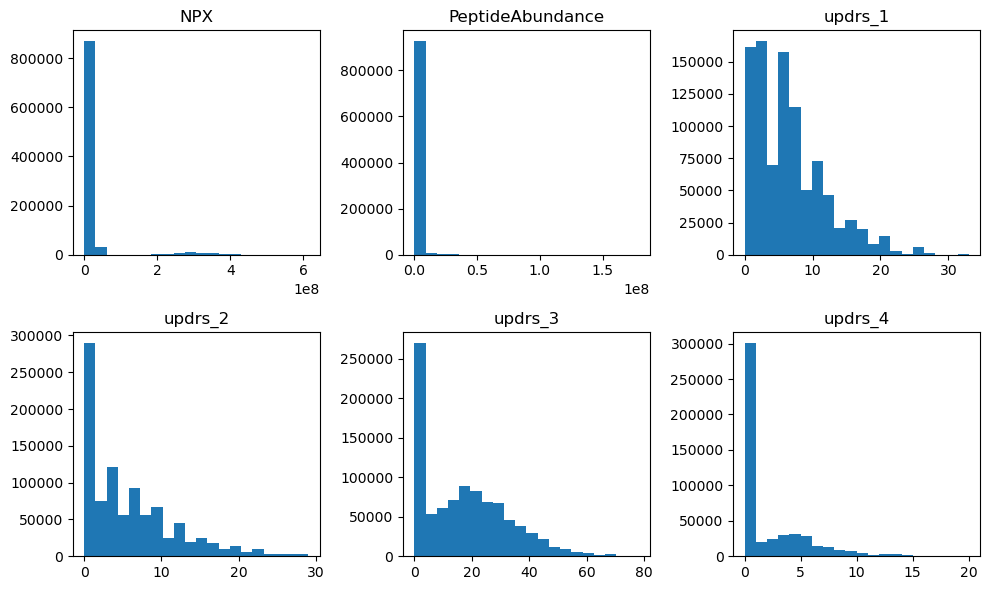

In [11]:
# Visualize NPX, PeptideAbundance, updrs_1, updrs_2, updrs_3, and updrs_4.

# Create a figure and axes for each variable
fig, axs = plt.subplots(nrows = 2, ncols = 3, figsize = (10, 6))
axs = axs.flatten()

# Plot histograms for each variable
for i, col in enumerate(['NPX', 'PeptideAbundance', 'updrs_1', 'updrs_2', 'updrs_3', 'updrs_4']):
    axs[i].hist(merged[col].dropna(), bins = 20)
    axs[i].set_title(col)

plt.tight_layout()
plt.show()

# The Relationship between Months and UPDRS Scores

PD is a progressive and intractable disease. It can be considered that the symptoms of PD patients **get worse over time** in spite of treatment. Thus, **the month of the visit may also be one factor** to determine the UPDRS scores. Thus, we make a figure to show the relationships between visit_month (x-axis) and updrs_1, updrs_2, updrs_3 , and updrs_4 (y-axis).

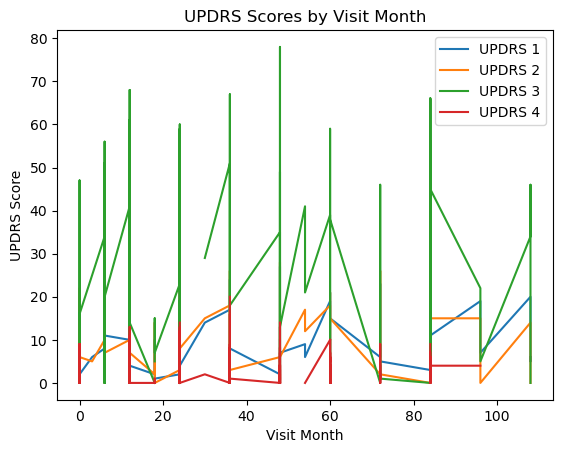

In [12]:
# Create a figure with one subplot.
fig, ax = plt.subplots()

# Plot the data as a line plot.
ax.plot(merged['visit_month'], merged['updrs_1'], label = 'UPDRS 1')
ax.plot(merged['visit_month'], merged['updrs_2'], label = 'UPDRS 2')
ax.plot(merged['visit_month'], merged['updrs_3'], label = 'UPDRS 3')
ax.plot(merged['visit_month'], merged['updrs_4'], label = 'UPDRS 4')

# Add a title and axis labels.
ax.set_title('UPDRS Scores by Visit Month')
ax.set_xlabel('Visit Month')
ax.set_ylabel('UPDRS Score')

# Add a legend.
ax.legend()

# Show the plot.
plt.show()

Unfortunately, this figure above does not clearly show the relationships.

We create a line plot showing **the mean UPDRS scores (UPDRS 1, UPDRS 2, UPDRS 3, and UPDRS 4) over time, grouped by visit month**. The x-axis shows the visit month, and the y-axis shows the UPDRS score.

The code first **calculates the mean UPDRS score for each visit month using the groupby method**. It then creates a new dataframe for **each UPDRS score with the mean values and visit months**. Finally, it plots each UPDRS score as a line using the plot method and adds a title, axis labels, and a legend using the relevant methods.

We can see that **these scores gradually increased over the period**.

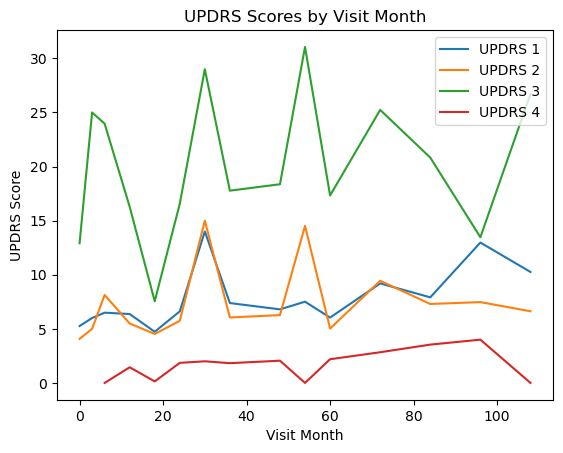

In [13]:
# Create a figure with one subplot.
fig, ax = plt.subplots()

# Calculate their mean values, then store the result in new dataframes.
merged_updrs_1 = merged.groupby('visit_month')['updrs_1'].mean().reset_index()
merged_updrs_2 = merged.groupby('visit_month')['updrs_2'].mean().reset_index()
merged_updrs_3 = merged.groupby('visit_month')['updrs_3'].mean().reset_index()
merged_updrs_4 = merged.groupby('visit_month')['updrs_4'].mean().reset_index()

# Plot the data as a line plot.
ax.plot(merged_updrs_1['visit_month'], merged_updrs_1['updrs_1'], label = 'UPDRS 1')
ax.plot(merged_updrs_2['visit_month'], merged_updrs_2['updrs_2'], label = 'UPDRS 2')
ax.plot(merged_updrs_3['visit_month'], merged_updrs_3['updrs_3'], label = 'UPDRS 3')
ax.plot(merged_updrs_4['visit_month'], merged_updrs_4['updrs_4'], label = 'UPDRS 4')

# Add a title and axis labels.
ax.set_title('UPDRS Scores by Visit Month')
ax.set_xlabel('Visit Month')
ax.set_ylabel('UPDRS Score')

# Add a legend.
ax.legend()

# Show the plot.
plt.show()

# Proteins and Peptides for Parkinson's Disease (Literature Review)

The present dataset includes information as to peptides and the protein that each peptide belongs to. PD is a neurodegenerative disease that is **caused by folding errors (misfolding) in proteins or peptides**, i.e. by changes in their spatial structure [[1]](https://www.news-medical.net/news/20220720/Simple-effective-method-can-detect-protein-misfolding-at-an-early-stage-of-neurodegenerative-disease.aspx). There are several proteins that have been linked to Parkinson’s disease such as **α-synuclein, T-tau, P-tau 181, and Aβ-42**. The plasma levels of these proteins have been studied in Parkinson’s disease patients to evaluate their relationship with PD motor subtypes [[2]](https://pubmed.ncbi.nlm.nih.gov/27878377/). **PD is caused by folding errors (misfolding) in proteins or peptides**, i.e. by changes in their spatial structure.

On the other hand, there are **some peptides that have been studied as drug candidates for PD**. For example, **AmyP53 is a therapeutic peptide candidate** for the treatment of Alzheimer’s and Parkinson’s disease [[3]](https://pubmed.ncbi.nlm.nih.gov/36362170/). Scientists at the University of Bath have refined a molecule that shows promise in preventing PD and has the potential to be developed into a drug to treat the deadly neurodegenerative disease [[4]](https://www.technologynetworks.com/biopharma/news/new-peptide-shows-promise-for-parkinsons-disease-356704). Brain-gut peptides have also been studied for their neuroprotective effects in Parkinson’s disease [[5]](https://pubmed.ncbi.nlm.nih.gov/31286411/). Thus, **some peptides are considered as drug treat PD by inhibiting toxic abnormal forms of proteins**.

**Next, we will see the relationship between peptides and proteins.**

In [14]:
merged['Peptide / Protein'] = merged['PeptideAbundance'] / merged['NPX']
merged

,visit_id,visit_month,patient_id,UniProt,NPX,Peptide,PeptideAbundance,updrs_1,updrs_2,updrs_3,updrs_4,upd23b_clinical_state_on_medication,Peptide / Protein
0,55_0,0,55,O00391,11254.3,NEQEQPLGQWHLS,11254.30,10.0,6.0,15.0,NaN,NaN,1.000000
1,55_0,0,55,O00533,732430.0,GNPEPTFSWTK,102060.00,10.0,6.0,15.0,NaN,NaN,0.139344
2,55_0,0,55,O00533,732430.0,IEIPSSVQQVPTIIK,174185.00,10.0,6.0,15.0,NaN,NaN,0.237818
3,55_0,0,55,O00533,732430.0,KPQSAVYSTGSNGILLC(UniMod_4)EAEGEPQPTIK,27278.90,10.0,6.0,15.0,NaN,NaN,0.037244
4,55_0,0,55,O00533,732430.0,SMEQNGPGLEYR,30838.70,10.0,6.0,15.0,NaN,NaN,0.042105
...,...,...,...,...,...,...,...,...,...,...,...,...,...
941739,58648_108,108,58648,Q9UHG2,369437.0,ILAGSADSEGVAAPR,202820.00,6.0,0.0,0.0,NaN,NaN,0.548998
941740,58648_108,108,58648,Q9UKV8,105830.0,SGNIPAGTTVDTK,105830.00,6.0,0.0,0.0,NaN,NaN,1.000000
941741,58648_108,108,58648,Q9Y646,21257.6,LALLVDTVGPR,21257.60,6.0,0.0,0.0,NaN,NaN,1.000000
941742,58648_108,108,58648,Q9Y6R7,17953.1,AGC(UniMod_4)VAESTAVC(UniMod_4)R,5127.26,6.0,0.0,0.0,NaN,NaN,0.285592


In [15]:
merged.describe()

,visit_month,patient_id,NPX,PeptideAbundance,updrs_1,updrs_2,updrs_3,updrs_4,Peptide / Protein
count,941744.000000,941744.000000,9.417440e+05,9.417440e+05,941744.000000,941744.000000,932624.000000,495530.000000,941744.000000
mean,26.771747,32682.203127,1.700905e+07,6.432814e+05,6.506168,5.781905,17.205189,1.887924,0.237079
std,22.889144,18608.454453,6.319169e+07,3.378418e+06,5.310697,5.920009,15.020913,3.047579,0.304005
min,0.000000,55.000000,8.460820e+01,1.099850e+01,0.000000,0.000000,0.000000,0.000000,0.000006
25%,6.000000,16574.000000,2.432950e+05,2.818738e+04,2.000000,1.000000,2.000000,0.000000,0.028978
50%,24.000000,29313.000000,9.928180e+05,7.435900e+04,5.000000,4.000000,16.000000,0.000000,0.099288
75%,48.000000,50611.000000,3.728860e+06,2.215240e+05,9.000000,9.000000,28.000000,3.000000,0.299806
max,108.000000,65043.000000,6.138510e+08,1.787520e+08,33.000000,29.000000,78.000000,20.000000,1.000000


**'Peptide / Protein' ranged from 0.000006 to 1.000000. Some peptides account for only a portion of a protein, while other peptides constitute all or substantially all of a protein.**  In addition, **once the sorts and amounts of peptides are identified, those of proteins will be also determined**. Therefore, **the information as to proteins might not be necessary**.

In [16]:
merged['Peptide'].value_counts()

YKAAFTEC(UniMod_4)C(UniMod_4)QAADK    1068
IPTTFENGR                             1068
AIGYLNTGYQR                           1068
TLLSNLEEAK                            1068
NILTSNNIDVK                           1068
                                      ... 
HYEGSTVPEK                             583
SLEDQVEMLR                             571
TPSGLYLGTC(UniMod_4)ER                 569
EPQVYTLPPSRDELTK                       539
QALPQVR                                467
Name: Peptide, Length: 968, dtype: int64

The length of 968 refers to the number of unique values in the 'Peptide' column of the dataframe 'merged'. This means that there are **968 different peptides** represented in the dataset.

The goal of this competition is to **predict the Unified Parkinson's Disease Rating Scale (MDS-UPDRS) scores by developing a model trained on data of protein and peptide levels over time in subjects having Parkinson’s disease (PD) and subjects without PD**.

Therefore, we need to create a data sheet that describes information as to **the 4 scores as dependent variables as well as visit months, peptides, and their peptide / protein ratio as independent variables**.

Let's **create a dataset in which index is 'visit_id', columns are 'visit_month', 'medication', and 'Peptide', and the values of Peptides are 'PeptideAbundance'**.

In [17]:
# Pivot the data.
pivoted = merged.pivot(index = 'visit_id', columns = ['Peptide'], values = 'PeptideAbundance')

# See the pivoted data.
pivoted

Peptide,AADDTWEPFASGK,AAFGQGSGPIMLDEVQC(UniMod_4)TGTEASLADC(UniMod_4)K,AAFTEC(UniMod_4)C(UniMod_4)QAADK,AANEVSSADVK,AATGEC(UniMod_4)TATVGKR,AATVGSLAGQPLQER,AAVYHHFISDGVR,ADDKETC(UniMod_4)FAEEGK,ADDKETC(UniMod_4)FAEEGKK,ADDLGKGGNEESTKTGNAGSR,...,YSLTYIYTGLSK,YTTEIIK,YVGGQEHFAHLLILR,YVM(UniMod_35)LPVADQDQC(UniMod_4)IR,YVMLPVADQDQC(UniMod_4)IR,YVNKEIQNAVNGVK,YWGVASFLQK,YYC(UniMod_4)FQGNQFLR,YYTYLIMNK,YYWGGQYTWDMAK
visit_id,,,,,,,,,,,,,,,,,,,,,
10053_0,6580710.0,31204.4,7735070.0,NaN,NaN,NaN,46620.3,236144.0,NaN,NaN,...,202274.0,NaN,4401830.0,77482.6,583075.0,76705.7,104260.0,530223.0,NaN,7207.30
10053_12,6333510.0,52277.6,5394390.0,NaN,NaN,NaN,57554.5,108298.0,45885.4,NaN,...,201009.0,NaN,5001750.0,36745.3,355643.0,92078.1,123254.0,453883.0,49281.9,25332.80
10053_18,7129640.0,61522.0,7011920.0,35984.7,17188.00,19787.3,36029.4,708729.0,5067790.0,30838.2,...,220728.0,NaN,5424380.0,39016.0,496021.0,63203.6,128336.0,447505.0,52389.1,21235.70
10138_12,7404780.0,46107.2,10610900.0,NaN,20910.20,66662.3,55253.9,79575.5,6201210.0,26720.0,...,188362.0,9433.71,3900280.0,48210.3,328482.0,89822.1,129964.0,552232.0,65657.8,9876.98
10138_24,13788300.0,56910.3,6906160.0,13785.5,11004.20,63672.7,36819.8,34160.9,2117430.0,15645.2,...,206187.0,6365.15,3521800.0,69984.6,496737.0,80919.3,111799.0,NaN,56977.6,4903.09
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8699_24,6312970.0,44462.7,12455000.0,11051.3,1163.18,43279.8,67743.5,325328.0,4666550.0,11038.5,...,289888.0,8615.27,8770410.0,33599.1,926094.0,118897.0,133682.0,571879.0,80268.3,54889.70
942_12,11289900.0,46111.7,11297300.0,NaN,13894.10,53755.0,40289.3,565112.0,NaN,26495.8,...,173259.0,4767.63,374307.0,35767.3,250397.0,65966.9,77976.8,486239.0,45032.7,NaN
942_24,10161900.0,32145.0,12388000.0,25869.2,17341.80,48625.5,45223.9,84448.0,4684800.0,23150.2,...,185428.0,5554.53,NaN,64049.8,479473.0,68505.7,74483.1,561398.0,52916.4,21847.60


In [18]:
# Add visit_month, the 4 scores, and medication status.
df = pd.merge(clinical, pivoted, on = 'visit_id', how = 'right').set_index('visit_id')
df

,patient_id,visit_month,updrs_1,updrs_2,updrs_3,updrs_4,upd23b_clinical_state_on_medication,AADDTWEPFASGK,AAFGQGSGPIMLDEVQC(UniMod_4)TGTEASLADC(UniMod_4)K,AAFTEC(UniMod_4)C(UniMod_4)QAADK,...,YSLTYIYTGLSK,YTTEIIK,YVGGQEHFAHLLILR,YVM(UniMod_35)LPVADQDQC(UniMod_4)IR,YVMLPVADQDQC(UniMod_4)IR,YVNKEIQNAVNGVK,YWGVASFLQK,YYC(UniMod_4)FQGNQFLR,YYTYLIMNK,YYWGGQYTWDMAK
visit_id,,,,,,,,,,,,,,,,,,,,,
10053_0,10053,0,3.0,0.0,13.0,0.0,NaN,6580710.0,31204.4,7735070.0,...,202274.0,NaN,4401830.0,77482.6,583075.0,76705.7,104260.0,530223.0,NaN,7207.30
10053_12,10053,12,4.0,2.0,8.0,0.0,NaN,6333510.0,52277.6,5394390.0,...,201009.0,NaN,5001750.0,36745.3,355643.0,92078.1,123254.0,453883.0,49281.9,25332.80
10053_18,10053,18,2.0,2.0,0.0,0.0,NaN,7129640.0,61522.0,7011920.0,...,220728.0,NaN,5424380.0,39016.0,496021.0,63203.6,128336.0,447505.0,52389.1,21235.70
10138_12,10138,12,3.0,6.0,31.0,0.0,On,7404780.0,46107.2,10610900.0,...,188362.0,9433.71,3900280.0,48210.3,328482.0,89822.1,129964.0,552232.0,65657.8,9876.98
10138_24,10138,24,4.0,7.0,19.0,10.0,On,13788300.0,56910.3,6906160.0,...,206187.0,6365.15,3521800.0,69984.6,496737.0,80919.3,111799.0,NaN,56977.6,4903.09
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8699_24,8699,24,11.0,10.0,13.0,2.0,On,6312970.0,44462.7,12455000.0,...,289888.0,8615.27,8770410.0,33599.1,926094.0,118897.0,133682.0,571879.0,80268.3,54889.70
942_12,942,12,5.0,2.0,25.0,0.0,NaN,11289900.0,46111.7,11297300.0,...,173259.0,4767.63,374307.0,35767.3,250397.0,65966.9,77976.8,486239.0,45032.7,NaN
942_24,942,24,2.0,3.0,23.0,NaN,NaN,10161900.0,32145.0,12388000.0,...,185428.0,5554.53,NaN,64049.8,479473.0,68505.7,74483.1,561398.0,52916.4,21847.60


In [19]:
# Insert the visit_month column to the desired position.
df.insert(6, 'visit_month', df.pop('visit_month'))
df

,patient_id,updrs_1,updrs_2,updrs_3,updrs_4,upd23b_clinical_state_on_medication,visit_month,AADDTWEPFASGK,AAFGQGSGPIMLDEVQC(UniMod_4)TGTEASLADC(UniMod_4)K,AAFTEC(UniMod_4)C(UniMod_4)QAADK,...,YSLTYIYTGLSK,YTTEIIK,YVGGQEHFAHLLILR,YVM(UniMod_35)LPVADQDQC(UniMod_4)IR,YVMLPVADQDQC(UniMod_4)IR,YVNKEIQNAVNGVK,YWGVASFLQK,YYC(UniMod_4)FQGNQFLR,YYTYLIMNK,YYWGGQYTWDMAK
visit_id,,,,,,,,,,,,,,,,,,,,,
10053_0,10053,3.0,0.0,13.0,0.0,NaN,0,6580710.0,31204.4,7735070.0,...,202274.0,NaN,4401830.0,77482.6,583075.0,76705.7,104260.0,530223.0,NaN,7207.30
10053_12,10053,4.0,2.0,8.0,0.0,NaN,12,6333510.0,52277.6,5394390.0,...,201009.0,NaN,5001750.0,36745.3,355643.0,92078.1,123254.0,453883.0,49281.9,25332.80
10053_18,10053,2.0,2.0,0.0,0.0,NaN,18,7129640.0,61522.0,7011920.0,...,220728.0,NaN,5424380.0,39016.0,496021.0,63203.6,128336.0,447505.0,52389.1,21235.70
10138_12,10138,3.0,6.0,31.0,0.0,On,12,7404780.0,46107.2,10610900.0,...,188362.0,9433.71,3900280.0,48210.3,328482.0,89822.1,129964.0,552232.0,65657.8,9876.98
10138_24,10138,4.0,7.0,19.0,10.0,On,24,13788300.0,56910.3,6906160.0,...,206187.0,6365.15,3521800.0,69984.6,496737.0,80919.3,111799.0,NaN,56977.6,4903.09
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8699_24,8699,11.0,10.0,13.0,2.0,On,24,6312970.0,44462.7,12455000.0,...,289888.0,8615.27,8770410.0,33599.1,926094.0,118897.0,133682.0,571879.0,80268.3,54889.70
942_12,942,5.0,2.0,25.0,0.0,NaN,12,11289900.0,46111.7,11297300.0,...,173259.0,4767.63,374307.0,35767.3,250397.0,65966.9,77976.8,486239.0,45032.7,NaN
942_24,942,2.0,3.0,23.0,NaN,NaN,24,10161900.0,32145.0,12388000.0,...,185428.0,5554.53,NaN,64049.8,479473.0,68505.7,74483.1,561398.0,52916.4,21847.60


In [20]:
df = df.drop('patient_id', axis = 1)
df

,updrs_1,updrs_2,updrs_3,updrs_4,upd23b_clinical_state_on_medication,visit_month,AADDTWEPFASGK,AAFGQGSGPIMLDEVQC(UniMod_4)TGTEASLADC(UniMod_4)K,AAFTEC(UniMod_4)C(UniMod_4)QAADK,AANEVSSADVK,...,YSLTYIYTGLSK,YTTEIIK,YVGGQEHFAHLLILR,YVM(UniMod_35)LPVADQDQC(UniMod_4)IR,YVMLPVADQDQC(UniMod_4)IR,YVNKEIQNAVNGVK,YWGVASFLQK,YYC(UniMod_4)FQGNQFLR,YYTYLIMNK,YYWGGQYTWDMAK
visit_id,,,,,,,,,,,,,,,,,,,,,
10053_0,3.0,0.0,13.0,0.0,NaN,0,6580710.0,31204.4,7735070.0,NaN,...,202274.0,NaN,4401830.0,77482.6,583075.0,76705.7,104260.0,530223.0,NaN,7207.30
10053_12,4.0,2.0,8.0,0.0,NaN,12,6333510.0,52277.6,5394390.0,NaN,...,201009.0,NaN,5001750.0,36745.3,355643.0,92078.1,123254.0,453883.0,49281.9,25332.80
10053_18,2.0,2.0,0.0,0.0,NaN,18,7129640.0,61522.0,7011920.0,35984.7,...,220728.0,NaN,5424380.0,39016.0,496021.0,63203.6,128336.0,447505.0,52389.1,21235.70
10138_12,3.0,6.0,31.0,0.0,On,12,7404780.0,46107.2,10610900.0,NaN,...,188362.0,9433.71,3900280.0,48210.3,328482.0,89822.1,129964.0,552232.0,65657.8,9876.98
10138_24,4.0,7.0,19.0,10.0,On,24,13788300.0,56910.3,6906160.0,13785.5,...,206187.0,6365.15,3521800.0,69984.6,496737.0,80919.3,111799.0,NaN,56977.6,4903.09
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8699_24,11.0,10.0,13.0,2.0,On,24,6312970.0,44462.7,12455000.0,11051.3,...,289888.0,8615.27,8770410.0,33599.1,926094.0,118897.0,133682.0,571879.0,80268.3,54889.70
942_12,5.0,2.0,25.0,0.0,NaN,12,11289900.0,46111.7,11297300.0,NaN,...,173259.0,4767.63,374307.0,35767.3,250397.0,65966.9,77976.8,486239.0,45032.7,NaN
942_24,2.0,3.0,23.0,NaN,NaN,24,10161900.0,32145.0,12388000.0,25869.2,...,185428.0,5554.53,NaN,64049.8,479473.0,68505.7,74483.1,561398.0,52916.4,21847.60


**Now we have 4 dependent variables in the left columns and many independent variables in the remaining right columns.**

In [21]:
df.describe()

,updrs_1,updrs_2,updrs_3,updrs_4,visit_month,AADDTWEPFASGK,AAFGQGSGPIMLDEVQC(UniMod_4)TGTEASLADC(UniMod_4)K,AAFTEC(UniMod_4)C(UniMod_4)QAADK,AANEVSSADVK,AATGEC(UniMod_4)TATVGKR,...,YSLTYIYTGLSK,YTTEIIK,YVGGQEHFAHLLILR,YVM(UniMod_35)LPVADQDQC(UniMod_4)IR,YVMLPVADQDQC(UniMod_4)IR,YVNKEIQNAVNGVK,YWGVASFLQK,YYC(UniMod_4)FQGNQFLR,YYTYLIMNK,YYWGGQYTWDMAK
count,1068.000000,1068.000000,1058.000000,569.000000,1068.000000,1.025000e+03,1004.000000,1.063000e+03,870.000000,876.000000,...,1055.000000,954.000000,9.780000e+02,937.000000,1.047000e+03,1066.000000,1045.000000,1060.000000,988.000000,831.000000
mean,6.566479,5.821161,17.300567,1.908612,26.744382,7.822847e+06,49325.741235,7.882716e+06,28200.897678,13149.197019,...,215475.070900,8996.806715,3.938239e+06,68394.594621,6.130732e+05,92668.876265,125754.068949,472235.953491,46987.825294,21042.291924
std,5.330702,5.931414,15.016371,3.077419,22.839426,3.748363e+06,16578.260141,2.740670e+06,13235.307619,5214.468176,...,50623.217419,3133.131758,1.693823e+06,61729.446386,4.995141e+05,30120.043449,38662.841093,130507.802755,13588.801150,10323.428949
min,0.000000,0.000000,0.000000,0.000000,0.000000,3.986000e+05,2941.840000,3.650100e+05,2226.960000,330.941000,...,12164.300000,258.249000,1.624640e+05,884.260000,7.494660e+03,869.898000,991.452000,11371.200000,6362.490000,868.903000
25%,2.000000,1.000000,2.000000,0.000000,6.000000,5.275490e+06,39845.150000,6.217920e+06,18601.150000,9990.272500,...,186590.000000,6889.352500,2.885028e+06,31059.200000,2.933840e+05,70498.725000,100519.000000,383522.500000,37550.550000,14224.900000
50%,5.000000,4.000000,16.000000,0.000000,24.000000,7.277070e+06,48241.450000,7.670750e+06,25888.350000,13113.200000,...,217313.000000,8583.870000,3.671010e+06,52728.800000,4.765030e+05,88856.600000,123254.000000,464041.500000,45540.200000,20390.900000
75%,9.000000,9.000000,28.000000,3.000000,48.000000,9.768580e+06,59480.950000,9.285105e+06,35687.275000,16480.500000,...,246435.000000,10581.150000,4.713422e+06,86892.900000,7.675465e+05,110147.500000,149616.000000,549588.500000,54477.125000,26898.000000
max,33.000000,29.000000,78.000000,20.000000,108.000000,3.431410e+07,110910.000000,2.063700e+07,94180.500000,28391.100000,...,409939.000000,27670.500000,1.385550e+07,712856.000000,3.984710e+06,251526.000000,264224.000000,948416.000000,107220.000000,70020.800000


In [22]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1068 entries, 10053_0 to 942_6
Columns: 974 entries, updrs_1 to YYWGGQYTWDMAK
dtypes: float64(972), int64(1), object(1)
memory usage: 7.9+ MB


In [23]:
# Check for NaN values in each column.
nan_count = df.isna().sum()
print(nan_count)

updrs_1                                  0
updrs_2                                  0
updrs_3                                 10
updrs_4                                499
upd23b_clinical_state_on_medication    616
                                      ... 
YVNKEIQNAVNGVK                           2
YWGVASFLQK                              23
YYC(UniMod_4)FQGNQFLR                    8
YYTYLIMNK                               80
YYWGGQYTWDMAK                          237
Length: 974, dtype: int64


We can consider that **'NaN' in the peptides columns means no existence of the peptide**. We **replace 'NaN' with 0**.

In [24]:
# Replace NaN with 0 in the Peptides columns.
df.loc[:, 'AADDTWEPFASGK':] = df.loc[:, 'AADDTWEPFASGK':].fillna(0)
df

,updrs_1,updrs_2,updrs_3,updrs_4,upd23b_clinical_state_on_medication,visit_month,AADDTWEPFASGK,AAFGQGSGPIMLDEVQC(UniMod_4)TGTEASLADC(UniMod_4)K,AAFTEC(UniMod_4)C(UniMod_4)QAADK,AANEVSSADVK,...,YSLTYIYTGLSK,YTTEIIK,YVGGQEHFAHLLILR,YVM(UniMod_35)LPVADQDQC(UniMod_4)IR,YVMLPVADQDQC(UniMod_4)IR,YVNKEIQNAVNGVK,YWGVASFLQK,YYC(UniMod_4)FQGNQFLR,YYTYLIMNK,YYWGGQYTWDMAK
visit_id,,,,,,,,,,,,,,,,,,,,,
10053_0,3.0,0.0,13.0,0.0,NaN,0,6580710.0,31204.4,7735070.0,0.0,...,202274.0,0.00,4401830.0,77482.6,583075.0,76705.7,104260.0,530223.0,0.0,7207.30
10053_12,4.0,2.0,8.0,0.0,NaN,12,6333510.0,52277.6,5394390.0,0.0,...,201009.0,0.00,5001750.0,36745.3,355643.0,92078.1,123254.0,453883.0,49281.9,25332.80
10053_18,2.0,2.0,0.0,0.0,NaN,18,7129640.0,61522.0,7011920.0,35984.7,...,220728.0,0.00,5424380.0,39016.0,496021.0,63203.6,128336.0,447505.0,52389.1,21235.70
10138_12,3.0,6.0,31.0,0.0,On,12,7404780.0,46107.2,10610900.0,0.0,...,188362.0,9433.71,3900280.0,48210.3,328482.0,89822.1,129964.0,552232.0,65657.8,9876.98
10138_24,4.0,7.0,19.0,10.0,On,24,13788300.0,56910.3,6906160.0,13785.5,...,206187.0,6365.15,3521800.0,69984.6,496737.0,80919.3,111799.0,0.0,56977.6,4903.09
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8699_24,11.0,10.0,13.0,2.0,On,24,6312970.0,44462.7,12455000.0,11051.3,...,289888.0,8615.27,8770410.0,33599.1,926094.0,118897.0,133682.0,571879.0,80268.3,54889.70
942_12,5.0,2.0,25.0,0.0,NaN,12,11289900.0,46111.7,11297300.0,0.0,...,173259.0,4767.63,374307.0,35767.3,250397.0,65966.9,77976.8,486239.0,45032.7,0.00
942_24,2.0,3.0,23.0,NaN,NaN,24,10161900.0,32145.0,12388000.0,25869.2,...,185428.0,5554.53,0.0,64049.8,479473.0,68505.7,74483.1,561398.0,52916.4,21847.60


In [25]:
# Check for NaN values in each column.
nan_count = df.isna().sum()
print(nan_count)

updrs_1                                  0
updrs_2                                  0
updrs_3                                 10
updrs_4                                499
upd23b_clinical_state_on_medication    616
                                      ... 
YVNKEIQNAVNGVK                           0
YWGVASFLQK                               0
YYC(UniMod_4)FQGNQFLR                    0
YYTYLIMNK                                0
YYWGGQYTWDMAK                            0
Length: 974, dtype: int64


In [26]:
print('Medication Status')
print(df.upd23b_clinical_state_on_medication.value_counts())
print(f"On or Off: {df['upd23b_clinical_state_on_medication'].count()}")
print(f"No Information: {df['upd23b_clinical_state_on_medication'].isna().sum()}")

Medication Status
On     229
Off    223
Name: upd23b_clinical_state_on_medication, dtype: int64
On or Off: 452
No Information: 616


Based on the information, it seems that the total number of non-null values in the 'upd23b_clinical_state_on_medication' column is 452, and there are 229 'On' values and 223 'Off' values. This means that there are **616 null values** in this column, indicating that there is no information available for those instances.

**If the medication status is included in the independent variables, the number of samples will be considerably reduced.**

**Next, let's see the test and sample submission files.**

# Read Test and Sample Submission CSV Files

## Test Proteins Data

In [27]:
test_proteins = pd.read_csv('/kaggle/input/amp-parkinsons-disease-progression-prediction/example_test_files/test_proteins.csv')
print('Test Proteins shape:',test_proteins.shape)
test_proteins.head()

Test Proteins shape: (453, 6)


,visit_id,visit_month,patient_id,UniProt,NPX,group_key
0,50423_0,0,50423,O00391,33127.90,0
1,50423_0,0,50423,O00533,490742.00,0
2,50423_0,0,50423,O00584,43615.30,0
3,50423_0,0,50423,O14773,16486.60,0
4,50423_0,0,50423,O14791,2882.42,0


## Test Peptides Data

In [28]:
test_peptides = pd.read_csv('/kaggle/input/amp-parkinsons-disease-progression-prediction/example_test_files/test_peptides.csv')
print('Test Peptides shape:', test_peptides.shape)
test_peptides.head()

Test Peptides shape: (2057, 7)


,visit_id,visit_month,patient_id,UniProt,Peptide,PeptideAbundance,group_key
0,50423_0,0,50423,O00391,AHFSPSNIILDFPAAGSAAR,22226.3,0
1,50423_0,0,50423,O00391,NEQEQPLGQWHLS,10901.6,0
2,50423_0,0,50423,O00533,GNPEPTFSWTK,51499.4,0
3,50423_0,0,50423,O00533,IEIPSSVQQVPTIIK,125492.0,0
4,50423_0,0,50423,O00533,KPQSAVYSTGSNGILLC(UniMod_4)EAEGEPQPTIK,23174.2,0


## Test Data

In [29]:
test = pd.read_csv('/kaggle/input/amp-parkinsons-disease-progression-prediction/example_test_files/test.csv')
print('Test shape:', test.shape)
test.head()

Test shape: (16, 6)


,visit_id,visit_month,patient_id,updrs_test,row_id,group_key
0,3342_0,0,3342,updrs_1,3342_0_updrs_1,0
1,3342_0,0,3342,updrs_2,3342_0_updrs_2,0
2,3342_0,0,3342,updrs_3,3342_0_updrs_3,0
3,3342_0,0,3342,updrs_4,3342_0_updrs_4,0
4,50423_0,0,50423,updrs_1,50423_0_updrs_1,0


**These test files are very similar to the 3 train proteins, peptides, and clinical files**, respectively. However, **the test files do not include information as to the medication status**.

## Sample Submission File

In [30]:
sample_submission = pd.read_csv('/kaggle/input/amp-parkinsons-disease-progression-prediction/example_test_files/sample_submission.csv')
print('Sample Submission shape:', sample_submission.shape)
sample_submission.head()

Sample Submission shape: (64, 3)


,prediction_id,rating,group_key
0,3342_0_updrs_1_plus_0_months,0,0
1,3342_0_updrs_1_plus_6_months,0,0
2,3342_0_updrs_1_plus_12_months,0,0
3,3342_0_updrs_1_plus_24_months,0,0
4,3342_0_updrs_2_plus_0_months,0,0


Considering these test and sample submission files, we are required to **predict the 4 UPDRS scores from the information as to visit months, peptides, and their peptide / protein ratio** as independent variables. It looks better to **remove the medication status from the independent variables to create a prediction model**.

# Create Test Dataset

**We will merge them in the same way as the train data.**

In [31]:
# Merge the proteins data and peptides data on the common columns.
test_merged_proteins_peptides = pd.merge(test_proteins, test_peptides, on = ['visit_id', 'visit_month', 'patient_id', 'UniProt'])

# Merge the merged protein-peptides data with the clinical data on the common columns.
test_merged = pd.merge(test_merged_proteins_peptides, test, on = ['visit_id', 'visit_month', 'patient_id'])

# Show the merged data.
test_merged

,visit_id,visit_month,patient_id,UniProt,NPX,group_key_x,Peptide,PeptideAbundance,group_key_y,updrs_test,row_id,group_key
0,50423_0,0,50423,O00391,33127.9,0,AHFSPSNIILDFPAAGSAAR,22226.30,0,updrs_1,50423_0_updrs_1,0
1,50423_0,0,50423,O00391,33127.9,0,AHFSPSNIILDFPAAGSAAR,22226.30,0,updrs_2,50423_0_updrs_2,0
2,50423_0,0,50423,O00391,33127.9,0,AHFSPSNIILDFPAAGSAAR,22226.30,0,updrs_3,50423_0_updrs_3,0
3,50423_0,0,50423,O00391,33127.9,0,AHFSPSNIILDFPAAGSAAR,22226.30,0,updrs_4,50423_0_updrs_4,0
4,50423_0,0,50423,O00391,33127.9,0,NEQEQPLGQWHLS,10901.60,0,updrs_1,50423_0_updrs_1,0
...,...,...,...,...,...,...,...,...,...,...,...,...
8223,3342_6,6,3342,Q9Y6R7,14624.5,6,AGC(UniMod_4)VAESTAVC(UniMod_4)R,4253.17,6,updrs_4,3342_6_updrs_4,6
8224,3342_6,6,3342,Q9Y6R7,14624.5,6,GATTSPGVYELSSR,10371.30,6,updrs_1,3342_6_updrs_1,6
8225,3342_6,6,3342,Q9Y6R7,14624.5,6,GATTSPGVYELSSR,10371.30,6,updrs_2,3342_6_updrs_2,6
8226,3342_6,6,3342,Q9Y6R7,14624.5,6,GATTSPGVYELSSR,10371.30,6,updrs_3,3342_6_updrs_3,6


In [32]:
test_merged.shape

(8228, 12)

**We have to create 'prediction_id' to merge the data and 'sample_submission' data.**

In [33]:
test_merged['prediction_id'] = test_merged.apply(lambda x: '{}_plus_{}months'.format(x['row_id'], x['visit_month']), axis = 1)
test_merged

,visit_id,visit_month,patient_id,UniProt,NPX,group_key_x,Peptide,PeptideAbundance,group_key_y,updrs_test,row_id,group_key,prediction_id
0,50423_0,0,50423,O00391,33127.9,0,AHFSPSNIILDFPAAGSAAR,22226.30,0,updrs_1,50423_0_updrs_1,0,50423_0_updrs_1_plus_0months
1,50423_0,0,50423,O00391,33127.9,0,AHFSPSNIILDFPAAGSAAR,22226.30,0,updrs_2,50423_0_updrs_2,0,50423_0_updrs_2_plus_0months
2,50423_0,0,50423,O00391,33127.9,0,AHFSPSNIILDFPAAGSAAR,22226.30,0,updrs_3,50423_0_updrs_3,0,50423_0_updrs_3_plus_0months
3,50423_0,0,50423,O00391,33127.9,0,AHFSPSNIILDFPAAGSAAR,22226.30,0,updrs_4,50423_0_updrs_4,0,50423_0_updrs_4_plus_0months
4,50423_0,0,50423,O00391,33127.9,0,NEQEQPLGQWHLS,10901.60,0,updrs_1,50423_0_updrs_1,0,50423_0_updrs_1_plus_0months
...,...,...,...,...,...,...,...,...,...,...,...,...,...
8223,3342_6,6,3342,Q9Y6R7,14624.5,6,AGC(UniMod_4)VAESTAVC(UniMod_4)R,4253.17,6,updrs_4,3342_6_updrs_4,6,3342_6_updrs_4_plus_6months
8224,3342_6,6,3342,Q9Y6R7,14624.5,6,GATTSPGVYELSSR,10371.30,6,updrs_1,3342_6_updrs_1,6,3342_6_updrs_1_plus_6months
8225,3342_6,6,3342,Q9Y6R7,14624.5,6,GATTSPGVYELSSR,10371.30,6,updrs_2,3342_6_updrs_2,6,3342_6_updrs_2_plus_6months
8226,3342_6,6,3342,Q9Y6R7,14624.5,6,GATTSPGVYELSSR,10371.30,6,updrs_3,3342_6_updrs_3,6,3342_6_updrs_3_plus_6months


**Calculate the value of 'Peptides / Proteins.'**

In [34]:
test_merged['Peptide / Protein'] = test_merged['PeptideAbundance'] / test_merged['NPX']
test_merged

,visit_id,visit_month,patient_id,UniProt,NPX,group_key_x,Peptide,PeptideAbundance,group_key_y,updrs_test,row_id,group_key,prediction_id,Peptide / Protein
0,50423_0,0,50423,O00391,33127.9,0,AHFSPSNIILDFPAAGSAAR,22226.30,0,updrs_1,50423_0_updrs_1,0,50423_0_updrs_1_plus_0months,0.670924
1,50423_0,0,50423,O00391,33127.9,0,AHFSPSNIILDFPAAGSAAR,22226.30,0,updrs_2,50423_0_updrs_2,0,50423_0_updrs_2_plus_0months,0.670924
2,50423_0,0,50423,O00391,33127.9,0,AHFSPSNIILDFPAAGSAAR,22226.30,0,updrs_3,50423_0_updrs_3,0,50423_0_updrs_3_plus_0months,0.670924
3,50423_0,0,50423,O00391,33127.9,0,AHFSPSNIILDFPAAGSAAR,22226.30,0,updrs_4,50423_0_updrs_4,0,50423_0_updrs_4_plus_0months,0.670924
4,50423_0,0,50423,O00391,33127.9,0,NEQEQPLGQWHLS,10901.60,0,updrs_1,50423_0_updrs_1,0,50423_0_updrs_1_plus_0months,0.329076
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8223,3342_6,6,3342,Q9Y6R7,14624.5,6,AGC(UniMod_4)VAESTAVC(UniMod_4)R,4253.17,6,updrs_4,3342_6_updrs_4,6,3342_6_updrs_4_plus_6months,0.290825
8224,3342_6,6,3342,Q9Y6R7,14624.5,6,GATTSPGVYELSSR,10371.30,6,updrs_1,3342_6_updrs_1,6,3342_6_updrs_1_plus_6months,0.709173
8225,3342_6,6,3342,Q9Y6R7,14624.5,6,GATTSPGVYELSSR,10371.30,6,updrs_2,3342_6_updrs_2,6,3342_6_updrs_2_plus_6months,0.709173
8226,3342_6,6,3342,Q9Y6R7,14624.5,6,GATTSPGVYELSSR,10371.30,6,updrs_3,3342_6_updrs_3,6,3342_6_updrs_3_plus_6months,0.709173


In [35]:
test_merged.describe()

,visit_month,patient_id,NPX,group_key_x,PeptideAbundance,group_key_y,group_key,Peptide / Protein
count,8228.000000,8228.000000,8.228000e+03,8228.000000,8.228000e+03,8228.000000,8228.000000,8228.000000
mean,3.021877,26710.838600,1.996236e+07,3.021877,6.525070e+05,3.021877,3.021877,0.220224
std,3.000103,23541.304703,7.470810e+07,3.000103,3.136614e+06,3.000103,3.000103,0.293019
min,0.000000,3342.000000,2.287040e+03,0.000000,8.860860e+02,0.000000,0.000000,0.000052
25%,0.000000,3342.000000,2.826670e+05,0.000000,2.636690e+04,0.000000,0.000000,0.024027
50%,6.000000,3342.000000,1.143980e+06,6.000000,7.291430e+04,6.000000,6.000000,0.086774
75%,6.000000,50423.000000,4.395120e+06,6.000000,2.084040e+05,6.000000,6.000000,0.277919
max,6.000000,50423.000000,4.392080e+08,6.000000,5.562260e+07,6.000000,6.000000,1.000000


**'Peptide / Protein' ranged from 0.000052 to 1.000000. Some peptides account for only a portion of a protein, while other peptides constitute all or substantially all of a protein.** In addition, **once the sorts and amounts of peptides are identified, those of proteins will be also determined**. Therefore, **the information as to proteins might not be necessary**.

**Create a dataset in which index is 'prediction_id', columns are 'visit_month' and 'Peptide', and the values of Peptides are 'PeptideAbundance.'**

In [36]:
# Pivot the data
test_pivoted = test_merged.pivot(index = 'prediction_id', columns = ['Peptide'], values = 'PeptideAbundance')

# See the pivoted data
test_pivoted

Peptide,AADDTWEPFASGK,AAFGQGSGPIMLDEVQC(UniMod_4)TGTEASLADC(UniMod_4)K,AAFTEC(UniMod_4)C(UniMod_4)QAADK,AANEVSSADVK,AATGEC(UniMod_4)TATVGKR,AATVGSLAGQPLQER,AAVYHHFISDGVR,AAVYHHFISDGVRK,AC(UniMod_4)DGINDC(UniMod_4)GDQSDELC(UniMod_4)C(UniMod_4)K,AC(UniMod_4)EPGVDYVYK,...,YSSDYFQAPSDYR,YTTEIIK,YVGGQEHFAHLLILR,YVM(UniMod_35)LPVADQDQC(UniMod_4)IR,YVMLPVADQDQC(UniMod_4)IR,YVNKEIQNAVNGVK,YWGVASFLQK,YYC(UniMod_4)FQGNQFLR,YYTYLIMNK,YYWGGQYTWDMAK
prediction_id,,,,,,,,,,,,,,,,,,,,,
3342_6_updrs_1_plus_6months,7579140.0,74133.6,7580720.0,45426.9,10180.3,85589.0,39353.0,67733.7,3581.33,58295.7,...,31145.7,10359.8,3657330.0,47100.5,1007150.0,74598.6,127126.0,210763.0,46207.2,22031.60
3342_6_updrs_2_plus_6months,7579140.0,74133.6,7580720.0,45426.9,10180.3,85589.0,39353.0,67733.7,3581.33,58295.7,...,31145.7,10359.8,3657330.0,47100.5,1007150.0,74598.6,127126.0,210763.0,46207.2,22031.60
3342_6_updrs_3_plus_6months,7579140.0,74133.6,7580720.0,45426.9,10180.3,85589.0,39353.0,67733.7,3581.33,58295.7,...,31145.7,10359.8,3657330.0,47100.5,1007150.0,74598.6,127126.0,210763.0,46207.2,22031.60
3342_6_updrs_4_plus_6months,7579140.0,74133.6,7580720.0,45426.9,10180.3,85589.0,39353.0,67733.7,3581.33,58295.7,...,31145.7,10359.8,3657330.0,47100.5,1007150.0,74598.6,127126.0,210763.0,46207.2,22031.60
50423_0_updrs_1_plus_0months,11087200.0,53998.5,9937660.0,25876.8,8013.8,42875.8,60326.2,63397.4,7721.18,75916.4,...,39620.5,15370.0,4137590.0,15217.0,83253.9,110941.0,112251.0,221372.0,46557.4,8527.23
50423_0_updrs_2_plus_0months,11087200.0,53998.5,9937660.0,25876.8,8013.8,42875.8,60326.2,63397.4,7721.18,75916.4,...,39620.5,15370.0,4137590.0,15217.0,83253.9,110941.0,112251.0,221372.0,46557.4,8527.23
50423_0_updrs_3_plus_0months,11087200.0,53998.5,9937660.0,25876.8,8013.8,42875.8,60326.2,63397.4,7721.18,75916.4,...,39620.5,15370.0,4137590.0,15217.0,83253.9,110941.0,112251.0,221372.0,46557.4,8527.23
50423_0_updrs_4_plus_0months,11087200.0,53998.5,9937660.0,25876.8,8013.8,42875.8,60326.2,63397.4,7721.18,75916.4,...,39620.5,15370.0,4137590.0,15217.0,83253.9,110941.0,112251.0,221372.0,46557.4,8527.23


In [37]:
# Check for NaN values in each column.
nan_count = test_pivoted.isna().sum()
print(nan_count)

Peptide
AADDTWEPFASGK                                       0
AAFGQGSGPIMLDEVQC(UniMod_4)TGTEASLADC(UniMod_4)K    0
AAFTEC(UniMod_4)C(UniMod_4)QAADK                    0
AANEVSSADVK                                         0
AATGEC(UniMod_4)TATVGKR                             0
                                                   ..
YVNKEIQNAVNGVK                                      0
YWGVASFLQK                                          0
YYC(UniMod_4)FQGNQFLR                               0
YYTYLIMNK                                           0
YYWGGQYTWDMAK                                       0
Length: 1077, dtype: int64


In [38]:
# Replace NaN with 0 in the Peptides columns.
test_pivoted.loc[:, 'AADDTWEPFASGK':] = test_pivoted.loc[:, 'AADDTWEPFASGK':].fillna(0)
test_pivoted

Peptide,AADDTWEPFASGK,AAFGQGSGPIMLDEVQC(UniMod_4)TGTEASLADC(UniMod_4)K,AAFTEC(UniMod_4)C(UniMod_4)QAADK,AANEVSSADVK,AATGEC(UniMod_4)TATVGKR,AATVGSLAGQPLQER,AAVYHHFISDGVR,AAVYHHFISDGVRK,AC(UniMod_4)DGINDC(UniMod_4)GDQSDELC(UniMod_4)C(UniMod_4)K,AC(UniMod_4)EPGVDYVYK,...,YSSDYFQAPSDYR,YTTEIIK,YVGGQEHFAHLLILR,YVM(UniMod_35)LPVADQDQC(UniMod_4)IR,YVMLPVADQDQC(UniMod_4)IR,YVNKEIQNAVNGVK,YWGVASFLQK,YYC(UniMod_4)FQGNQFLR,YYTYLIMNK,YYWGGQYTWDMAK
prediction_id,,,,,,,,,,,,,,,,,,,,,
3342_6_updrs_1_plus_6months,7579140.0,74133.6,7580720.0,45426.9,10180.3,85589.0,39353.0,67733.7,3581.33,58295.7,...,31145.7,10359.8,3657330.0,47100.5,1007150.0,74598.6,127126.0,210763.0,46207.2,22031.60
3342_6_updrs_2_plus_6months,7579140.0,74133.6,7580720.0,45426.9,10180.3,85589.0,39353.0,67733.7,3581.33,58295.7,...,31145.7,10359.8,3657330.0,47100.5,1007150.0,74598.6,127126.0,210763.0,46207.2,22031.60
3342_6_updrs_3_plus_6months,7579140.0,74133.6,7580720.0,45426.9,10180.3,85589.0,39353.0,67733.7,3581.33,58295.7,...,31145.7,10359.8,3657330.0,47100.5,1007150.0,74598.6,127126.0,210763.0,46207.2,22031.60
3342_6_updrs_4_plus_6months,7579140.0,74133.6,7580720.0,45426.9,10180.3,85589.0,39353.0,67733.7,3581.33,58295.7,...,31145.7,10359.8,3657330.0,47100.5,1007150.0,74598.6,127126.0,210763.0,46207.2,22031.60
50423_0_updrs_1_plus_0months,11087200.0,53998.5,9937660.0,25876.8,8013.8,42875.8,60326.2,63397.4,7721.18,75916.4,...,39620.5,15370.0,4137590.0,15217.0,83253.9,110941.0,112251.0,221372.0,46557.4,8527.23
50423_0_updrs_2_plus_0months,11087200.0,53998.5,9937660.0,25876.8,8013.8,42875.8,60326.2,63397.4,7721.18,75916.4,...,39620.5,15370.0,4137590.0,15217.0,83253.9,110941.0,112251.0,221372.0,46557.4,8527.23
50423_0_updrs_3_plus_0months,11087200.0,53998.5,9937660.0,25876.8,8013.8,42875.8,60326.2,63397.4,7721.18,75916.4,...,39620.5,15370.0,4137590.0,15217.0,83253.9,110941.0,112251.0,221372.0,46557.4,8527.23
50423_0_updrs_4_plus_0months,11087200.0,53998.5,9937660.0,25876.8,8013.8,42875.8,60326.2,63397.4,7721.18,75916.4,...,39620.5,15370.0,4137590.0,15217.0,83253.9,110941.0,112251.0,221372.0,46557.4,8527.23


**Unfortunately, we cannot merge the data and 'sample_submission' data, because the number of rows is different.**

In [39]:
# We need to remove duplicates by patient_id.
index_list = list(test_pivoted.index)
patient_id = []
for i in range(len(test_pivoted)):
    element = index_list[i].split('_')[0]
    patient_id.append(element)
    
patient_id

['3342', '3342', '3342', '3342', '50423', '50423', '50423', '50423']

In [40]:
test_pivoted['patient_id'] = patient_id
test_pivoted

Peptide,AADDTWEPFASGK,AAFGQGSGPIMLDEVQC(UniMod_4)TGTEASLADC(UniMod_4)K,AAFTEC(UniMod_4)C(UniMod_4)QAADK,AANEVSSADVK,AATGEC(UniMod_4)TATVGKR,AATVGSLAGQPLQER,AAVYHHFISDGVR,AAVYHHFISDGVRK,AC(UniMod_4)DGINDC(UniMod_4)GDQSDELC(UniMod_4)C(UniMod_4)K,AC(UniMod_4)EPGVDYVYK,...,YTTEIIK,YVGGQEHFAHLLILR,YVM(UniMod_35)LPVADQDQC(UniMod_4)IR,YVMLPVADQDQC(UniMod_4)IR,YVNKEIQNAVNGVK,YWGVASFLQK,YYC(UniMod_4)FQGNQFLR,YYTYLIMNK,YYWGGQYTWDMAK,patient_id
prediction_id,,,,,,,,,,,,,,,,,,,,,
3342_6_updrs_1_plus_6months,7579140.0,74133.6,7580720.0,45426.9,10180.3,85589.0,39353.0,67733.7,3581.33,58295.7,...,10359.8,3657330.0,47100.5,1007150.0,74598.6,127126.0,210763.0,46207.2,22031.60,3342
3342_6_updrs_2_plus_6months,7579140.0,74133.6,7580720.0,45426.9,10180.3,85589.0,39353.0,67733.7,3581.33,58295.7,...,10359.8,3657330.0,47100.5,1007150.0,74598.6,127126.0,210763.0,46207.2,22031.60,3342
3342_6_updrs_3_plus_6months,7579140.0,74133.6,7580720.0,45426.9,10180.3,85589.0,39353.0,67733.7,3581.33,58295.7,...,10359.8,3657330.0,47100.5,1007150.0,74598.6,127126.0,210763.0,46207.2,22031.60,3342
3342_6_updrs_4_plus_6months,7579140.0,74133.6,7580720.0,45426.9,10180.3,85589.0,39353.0,67733.7,3581.33,58295.7,...,10359.8,3657330.0,47100.5,1007150.0,74598.6,127126.0,210763.0,46207.2,22031.60,3342
50423_0_updrs_1_plus_0months,11087200.0,53998.5,9937660.0,25876.8,8013.8,42875.8,60326.2,63397.4,7721.18,75916.4,...,15370.0,4137590.0,15217.0,83253.9,110941.0,112251.0,221372.0,46557.4,8527.23,50423
50423_0_updrs_2_plus_0months,11087200.0,53998.5,9937660.0,25876.8,8013.8,42875.8,60326.2,63397.4,7721.18,75916.4,...,15370.0,4137590.0,15217.0,83253.9,110941.0,112251.0,221372.0,46557.4,8527.23,50423
50423_0_updrs_3_plus_0months,11087200.0,53998.5,9937660.0,25876.8,8013.8,42875.8,60326.2,63397.4,7721.18,75916.4,...,15370.0,4137590.0,15217.0,83253.9,110941.0,112251.0,221372.0,46557.4,8527.23,50423
50423_0_updrs_4_plus_0months,11087200.0,53998.5,9937660.0,25876.8,8013.8,42875.8,60326.2,63397.4,7721.18,75916.4,...,15370.0,4137590.0,15217.0,83253.9,110941.0,112251.0,221372.0,46557.4,8527.23,50423


In [41]:
test_pivoted = test_pivoted.drop_duplicates(subset = 'patient_id')
patient_id = test_pivoted.pop('patient_id')
test_pivoted.insert(0, 'patient_id', patient_id)
test_pivoted

Peptide,patient_id,AADDTWEPFASGK,AAFGQGSGPIMLDEVQC(UniMod_4)TGTEASLADC(UniMod_4)K,AAFTEC(UniMod_4)C(UniMod_4)QAADK,AANEVSSADVK,AATGEC(UniMod_4)TATVGKR,AATVGSLAGQPLQER,AAVYHHFISDGVR,AAVYHHFISDGVRK,AC(UniMod_4)DGINDC(UniMod_4)GDQSDELC(UniMod_4)C(UniMod_4)K,...,YSSDYFQAPSDYR,YTTEIIK,YVGGQEHFAHLLILR,YVM(UniMod_35)LPVADQDQC(UniMod_4)IR,YVMLPVADQDQC(UniMod_4)IR,YVNKEIQNAVNGVK,YWGVASFLQK,YYC(UniMod_4)FQGNQFLR,YYTYLIMNK,YYWGGQYTWDMAK
prediction_id,,,,,,,,,,,,,,,,,,,,,
3342_6_updrs_1_plus_6months,3342,7579140.0,74133.6,7580720.0,45426.9,10180.3,85589.0,39353.0,67733.7,3581.33,...,31145.7,10359.8,3657330.0,47100.5,1007150.0,74598.6,127126.0,210763.0,46207.2,22031.60
50423_0_updrs_1_plus_0months,50423,11087200.0,53998.5,9937660.0,25876.8,8013.8,42875.8,60326.2,63397.4,7721.18,...,39620.5,15370.0,4137590.0,15217.0,83253.9,110941.0,112251.0,221372.0,46557.4,8527.23


In [42]:
# We need to crate visit_month in sample submission.
index_list = list(sample_submission.prediction_id)
patient_id = []
for i in range(len(sample_submission)):
    element = index_list[i].split('_')[0]
    patient_id.append(element)
    
print(patient_id)

['3342', '3342', '3342', '3342', '3342', '3342', '3342', '3342', '3342', '3342', '3342', '3342', '3342', '3342', '3342', '3342', '50423', '50423', '50423', '50423', '50423', '50423', '50423', '50423', '50423', '50423', '50423', '50423', '50423', '50423', '50423', '50423', '3342', '3342', '3342', '3342', '3342', '3342', '3342', '3342', '3342', '3342', '3342', '3342', '3342', '3342', '3342', '3342', '50423', '50423', '50423', '50423', '50423', '50423', '50423', '50423', '50423', '50423', '50423', '50423', '50423', '50423', '50423', '50423']


In [43]:
sample_submission['patient_id'] = patient_id
sample_submission

,prediction_id,rating,group_key,patient_id
0,3342_0_updrs_1_plus_0_months,0,0,3342
1,3342_0_updrs_1_plus_6_months,0,0,3342
2,3342_0_updrs_1_plus_12_months,0,0,3342
3,3342_0_updrs_1_plus_24_months,0,0,3342
4,3342_0_updrs_2_plus_0_months,0,0,3342
...,...,...,...,...
59,50423_6_updrs_3_plus_24_months,0,6,50423
60,50423_6_updrs_4_plus_0_months,0,6,50423
61,50423_6_updrs_4_plus_6_months,0,6,50423
62,50423_6_updrs_4_plus_12_months,0,6,50423


In [44]:
# We need to crate updrs in sample submission.
index_list = list(sample_submission.prediction_id)
updrs = []
for i in range(len(sample_submission)):
    element = index_list[i].split('_')[3]
    updrs.append(element)
    
print(updrs)

['1', '1', '1', '1', '2', '2', '2', '2', '3', '3', '3', '3', '4', '4', '4', '4', '1', '1', '1', '1', '2', '2', '2', '2', '3', '3', '3', '3', '4', '4', '4', '4', '1', '1', '1', '1', '2', '2', '2', '2', '3', '3', '3', '3', '4', '4', '4', '4', '1', '1', '1', '1', '2', '2', '2', '2', '3', '3', '3', '3', '4', '4', '4', '4']


In [45]:
sample_submission['updrs'] = updrs
sample_submission

,prediction_id,rating,group_key,patient_id,updrs
0,3342_0_updrs_1_plus_0_months,0,0,3342,1
1,3342_0_updrs_1_plus_6_months,0,0,3342,1
2,3342_0_updrs_1_plus_12_months,0,0,3342,1
3,3342_0_updrs_1_plus_24_months,0,0,3342,1
4,3342_0_updrs_2_plus_0_months,0,0,3342,2
...,...,...,...,...,...
59,50423_6_updrs_3_plus_24_months,0,6,50423,3
60,50423_6_updrs_4_plus_0_months,0,6,50423,4
61,50423_6_updrs_4_plus_6_months,0,6,50423,4
62,50423_6_updrs_4_plus_12_months,0,6,50423,4


In [46]:
# We need to crate patient_id in sample submission.
index_list = list(sample_submission.prediction_id)
visit_month = []
for i in range(len(sample_submission)):
    element = index_list[i].split('_')[-2]
    visit_month.append(element)
    
print(visit_month)

['0', '6', '12', '24', '0', '6', '12', '24', '0', '6', '12', '24', '0', '6', '12', '24', '0', '6', '12', '24', '0', '6', '12', '24', '0', '6', '12', '24', '0', '6', '12', '24', '0', '6', '12', '24', '0', '6', '12', '24', '0', '6', '12', '24', '0', '6', '12', '24', '0', '6', '12', '24', '0', '6', '12', '24', '0', '6', '12', '24', '0', '6', '12', '24']


In [47]:
sample_submission['visit_month'] = visit_month
sample_submission

,prediction_id,rating,group_key,patient_id,updrs,visit_month
0,3342_0_updrs_1_plus_0_months,0,0,3342,1,0
1,3342_0_updrs_1_plus_6_months,0,0,3342,1,6
2,3342_0_updrs_1_plus_12_months,0,0,3342,1,12
3,3342_0_updrs_1_plus_24_months,0,0,3342,1,24
4,3342_0_updrs_2_plus_0_months,0,0,3342,2,0
...,...,...,...,...,...,...
59,50423_6_updrs_3_plus_24_months,0,6,50423,3,24
60,50423_6_updrs_4_plus_0_months,0,6,50423,4,0
61,50423_6_updrs_4_plus_6_months,0,6,50423,4,6
62,50423_6_updrs_4_plus_12_months,0,6,50423,4,12


In [48]:
# Merge the data and sample_submission, while keeping the order of rows of sample_submission.
test_df = pd.merge(sample_submission, test_pivoted, on = ['patient_id'], how = 'left')
test_df

,prediction_id,rating,group_key,patient_id,updrs,visit_month,AADDTWEPFASGK,AAFGQGSGPIMLDEVQC(UniMod_4)TGTEASLADC(UniMod_4)K,AAFTEC(UniMod_4)C(UniMod_4)QAADK,AANEVSSADVK,...,YSSDYFQAPSDYR,YTTEIIK,YVGGQEHFAHLLILR,YVM(UniMod_35)LPVADQDQC(UniMod_4)IR,YVMLPVADQDQC(UniMod_4)IR,YVNKEIQNAVNGVK,YWGVASFLQK,YYC(UniMod_4)FQGNQFLR,YYTYLIMNK,YYWGGQYTWDMAK
0,3342_0_updrs_1_plus_0_months,0,0,3342,1,0,7579140.0,74133.6,7580720.0,45426.9,...,31145.7,10359.8,3657330.0,47100.5,1007150.0,74598.6,127126.0,210763.0,46207.2,22031.60
1,3342_0_updrs_1_plus_6_months,0,0,3342,1,6,7579140.0,74133.6,7580720.0,45426.9,...,31145.7,10359.8,3657330.0,47100.5,1007150.0,74598.6,127126.0,210763.0,46207.2,22031.60
2,3342_0_updrs_1_plus_12_months,0,0,3342,1,12,7579140.0,74133.6,7580720.0,45426.9,...,31145.7,10359.8,3657330.0,47100.5,1007150.0,74598.6,127126.0,210763.0,46207.2,22031.60
3,3342_0_updrs_1_plus_24_months,0,0,3342,1,24,7579140.0,74133.6,7580720.0,45426.9,...,31145.7,10359.8,3657330.0,47100.5,1007150.0,74598.6,127126.0,210763.0,46207.2,22031.60
4,3342_0_updrs_2_plus_0_months,0,0,3342,2,0,7579140.0,74133.6,7580720.0,45426.9,...,31145.7,10359.8,3657330.0,47100.5,1007150.0,74598.6,127126.0,210763.0,46207.2,22031.60
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
59,50423_6_updrs_3_plus_24_months,0,6,50423,3,24,11087200.0,53998.5,9937660.0,25876.8,...,39620.5,15370.0,4137590.0,15217.0,83253.9,110941.0,112251.0,221372.0,46557.4,8527.23
60,50423_6_updrs_4_plus_0_months,0,6,50423,4,0,11087200.0,53998.5,9937660.0,25876.8,...,39620.5,15370.0,4137590.0,15217.0,83253.9,110941.0,112251.0,221372.0,46557.4,8527.23
61,50423_6_updrs_4_plus_6_months,0,6,50423,4,6,11087200.0,53998.5,9937660.0,25876.8,...,39620.5,15370.0,4137590.0,15217.0,83253.9,110941.0,112251.0,221372.0,46557.4,8527.23
62,50423_6_updrs_4_plus_12_months,0,6,50423,4,12,11087200.0,53998.5,9937660.0,25876.8,...,39620.5,15370.0,4137590.0,15217.0,83253.9,110941.0,112251.0,221372.0,46557.4,8527.23


In [49]:
(test_df['prediction_id'] == sample_submission['prediction_id']).sum()

64

In [50]:
len(list(df.columns[5:].values))

969

In [51]:
len(list(test_df.columns[6:].values))

1077

**Unfortunately, peptides in the train dataset are different from those in the test dataset, and the common peptides must be selected from both dataset.**

# Final Independent and Dependent Variables

## Select Independent Variables for Train Dataset

In [52]:
# Drop upd23b_clinical_state_on_medication column from the previous merged train dataset df.
df = df.drop('upd23b_clinical_state_on_medication', axis = 1)
df

,updrs_1,updrs_2,updrs_3,updrs_4,visit_month,AADDTWEPFASGK,AAFGQGSGPIMLDEVQC(UniMod_4)TGTEASLADC(UniMod_4)K,AAFTEC(UniMod_4)C(UniMod_4)QAADK,AANEVSSADVK,AATGEC(UniMod_4)TATVGKR,...,YSLTYIYTGLSK,YTTEIIK,YVGGQEHFAHLLILR,YVM(UniMod_35)LPVADQDQC(UniMod_4)IR,YVMLPVADQDQC(UniMod_4)IR,YVNKEIQNAVNGVK,YWGVASFLQK,YYC(UniMod_4)FQGNQFLR,YYTYLIMNK,YYWGGQYTWDMAK
visit_id,,,,,,,,,,,,,,,,,,,,,
10053_0,3.0,0.0,13.0,0.0,0,6580710.0,31204.4,7735070.0,0.0,0.00,...,202274.0,0.00,4401830.0,77482.6,583075.0,76705.7,104260.0,530223.0,0.0,7207.30
10053_12,4.0,2.0,8.0,0.0,12,6333510.0,52277.6,5394390.0,0.0,0.00,...,201009.0,0.00,5001750.0,36745.3,355643.0,92078.1,123254.0,453883.0,49281.9,25332.80
10053_18,2.0,2.0,0.0,0.0,18,7129640.0,61522.0,7011920.0,35984.7,17188.00,...,220728.0,0.00,5424380.0,39016.0,496021.0,63203.6,128336.0,447505.0,52389.1,21235.70
10138_12,3.0,6.0,31.0,0.0,12,7404780.0,46107.2,10610900.0,0.0,20910.20,...,188362.0,9433.71,3900280.0,48210.3,328482.0,89822.1,129964.0,552232.0,65657.8,9876.98
10138_24,4.0,7.0,19.0,10.0,24,13788300.0,56910.3,6906160.0,13785.5,11004.20,...,206187.0,6365.15,3521800.0,69984.6,496737.0,80919.3,111799.0,0.0,56977.6,4903.09
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8699_24,11.0,10.0,13.0,2.0,24,6312970.0,44462.7,12455000.0,11051.3,1163.18,...,289888.0,8615.27,8770410.0,33599.1,926094.0,118897.0,133682.0,571879.0,80268.3,54889.70
942_12,5.0,2.0,25.0,0.0,12,11289900.0,46111.7,11297300.0,0.0,13894.10,...,173259.0,4767.63,374307.0,35767.3,250397.0,65966.9,77976.8,486239.0,45032.7,0.00
942_24,2.0,3.0,23.0,NaN,24,10161900.0,32145.0,12388000.0,25869.2,17341.80,...,185428.0,5554.53,0.0,64049.8,479473.0,68505.7,74483.1,561398.0,52916.4,21847.60


In [53]:
# If a peptide in the train dataset does not exist in the test dataset, remove it.
remove_train = []
for i in range(len(list(df.columns[5:].values))):
    if list(df.columns[5:].values)[i] not in list(test_df.columns[6:].values):
        remove_train.append(list(df.columns[5:].values)[i])
        
remove_train

['C(UniMod_4)C(UniMod_4)VEC(UniMod_4)PPC(UniMod_4)PAPPVAGPSVFLFPPKPK',
 'DALSSVQESQVAQQAR',
 'DC(UniMod_4)GSVDGVIKEVNVSPC(UniMod_4)PTQPC(UniMod_4)QLSK',
 'DRLDEVKEQVAEVR',
 'DSGVPDRFSGSGSGTDFTLK',
 'DYVSQFEGSALGK',
 'EKLQDEDLGFL',
 'EPQVYTLPPSRDELTK',
 'FSALEVDETYVPK',
 'GGTLGTPQTGSENDALYEYLR',
 'HGNVAEGETKPDPDVTER',
 'LAAC(UniMod_4)GPPPVAPPAAVAAVAGGAR',
 'LEPGQQEEYYR',
 'LYQQHGAGLFDVTR',
 'QALNTDYLDSDYQR',
 'QALPQVR',
 'QQLVETHMAR',
 'RYIETDPANRDR',
 'SLEDQVEMLR',
 'TINPAVDHC(UniMod_4)C(UniMod_4)K',
 'TPVSDRVTK',
 'TSPVDEKALQDQLVLVAAK',
 'VAHQLQALR',
 'VPEEDLKR',
 'VSEADIQR']

In [54]:
df = df.drop(remove_train, axis = 1)
df

,updrs_1,updrs_2,updrs_3,updrs_4,visit_month,AADDTWEPFASGK,AAFGQGSGPIMLDEVQC(UniMod_4)TGTEASLADC(UniMod_4)K,AAFTEC(UniMod_4)C(UniMod_4)QAADK,AANEVSSADVK,AATGEC(UniMod_4)TATVGKR,...,YSLTYIYTGLSK,YTTEIIK,YVGGQEHFAHLLILR,YVM(UniMod_35)LPVADQDQC(UniMod_4)IR,YVMLPVADQDQC(UniMod_4)IR,YVNKEIQNAVNGVK,YWGVASFLQK,YYC(UniMod_4)FQGNQFLR,YYTYLIMNK,YYWGGQYTWDMAK
visit_id,,,,,,,,,,,,,,,,,,,,,
10053_0,3.0,0.0,13.0,0.0,0,6580710.0,31204.4,7735070.0,0.0,0.00,...,202274.0,0.00,4401830.0,77482.6,583075.0,76705.7,104260.0,530223.0,0.0,7207.30
10053_12,4.0,2.0,8.0,0.0,12,6333510.0,52277.6,5394390.0,0.0,0.00,...,201009.0,0.00,5001750.0,36745.3,355643.0,92078.1,123254.0,453883.0,49281.9,25332.80
10053_18,2.0,2.0,0.0,0.0,18,7129640.0,61522.0,7011920.0,35984.7,17188.00,...,220728.0,0.00,5424380.0,39016.0,496021.0,63203.6,128336.0,447505.0,52389.1,21235.70
10138_12,3.0,6.0,31.0,0.0,12,7404780.0,46107.2,10610900.0,0.0,20910.20,...,188362.0,9433.71,3900280.0,48210.3,328482.0,89822.1,129964.0,552232.0,65657.8,9876.98
10138_24,4.0,7.0,19.0,10.0,24,13788300.0,56910.3,6906160.0,13785.5,11004.20,...,206187.0,6365.15,3521800.0,69984.6,496737.0,80919.3,111799.0,0.0,56977.6,4903.09
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8699_24,11.0,10.0,13.0,2.0,24,6312970.0,44462.7,12455000.0,11051.3,1163.18,...,289888.0,8615.27,8770410.0,33599.1,926094.0,118897.0,133682.0,571879.0,80268.3,54889.70
942_12,5.0,2.0,25.0,0.0,12,11289900.0,46111.7,11297300.0,0.0,13894.10,...,173259.0,4767.63,374307.0,35767.3,250397.0,65966.9,77976.8,486239.0,45032.7,0.00
942_24,2.0,3.0,23.0,NaN,24,10161900.0,32145.0,12388000.0,25869.2,17341.80,...,185428.0,5554.53,0.0,64049.8,479473.0,68505.7,74483.1,561398.0,52916.4,21847.60


## Select Independent Variables for Test Dataset

**We want to remove the Peptide columns from test_df (test dataset) that do not exist in df (train dataset).**

In [55]:
# If a peptide in the test dataset does not exist in the train dataset, remove it.
remove_test = []
for i in range(len(list(test_df.columns[6:].values))):
    if list(test_df.columns[6:].values)[i] not in list(df.columns[5:].values):
        remove_test.append(list(test_df.columns[6:].values)[i])
        
remove_test

['AAVYHHFISDGVRK',
 'AC(UniMod_4)DGINDC(UniMod_4)GDQSDELC(UniMod_4)C(UniMod_4)K',
 'AC(UniMod_4)EPGVDYVYK',
 'AEAQAQYSAAVAK',
 'AHFSPSNIILDFPAAGSAAR',
 'AIINLAVYGK',
 'APLQGTLLGYR',
 'APSVPAAEPEYPK',
 'AVC(UniMod_4)VLKGDGPVQGIINFEQK',
 'C(UniMod_4)C(UniMod_4)TESLVNRRPC(UniMod_4)FSALEVDETYVPK',
 'C(UniMod_4)DEWSVNSVGKIEC(UniMod_4)VSAETTEDC(UniMod_4)IAK',
 'C(UniMod_4)FEPQLLR',
 'C(UniMod_4)VC(UniMod_4)PVSNAM(UniMod_35)C(UniMod_4)R',
 'DGSTIPIAK',
 'DIC(UniMod_4)EEQVNSLPGSITK',
 'DKATFGC(UniMod_4)HDGYSLDGPEEIEC(UniMod_4)TK',
 'DPNGLPPEAQK',
 'DRDGNTLTYYR',
 'DSAHGFLK',
 'DSTGTYTC(UniMod_4)VAR',
 'EDGGGWWYNR',
 'EFQLFSSPHGKDLLFK',
 'EGDALELTC(UniMod_4)EAIGKPQPVMVTWVR',
 'EGTC(UniMod_4)PEAPTDEC(UniMod_4)KPVKWC(UniMod_4)ALSHHER',
 'ETPAATEAPSSTPK',
 'EVPLNTIIFM(UniMod_35)GR',
 'EYLGAIC(UniMod_4)SC(UniMod_4)TC(UniMod_4)FGGQR',
 'FISLGEAC(UniMod_4)K',
 'FNAVLTNPQGDYDTSTGK',
 'FPVFMGR',
 'GDGPVQGIINFEQK',
 'GDSPASSKPISINYR',
 'GELDC(UniMod_4)HQLADSFRE',
 'GEQEHSQQKEEEEEMAVVPQGLFR',
 'GFNC(UniM

In [56]:
test_df = test_df.drop(remove_test, axis = 1)
test_df

,prediction_id,rating,group_key,patient_id,updrs,visit_month,AADDTWEPFASGK,AAFGQGSGPIMLDEVQC(UniMod_4)TGTEASLADC(UniMod_4)K,AAFTEC(UniMod_4)C(UniMod_4)QAADK,AANEVSSADVK,...,YSLTYIYTGLSK,YTTEIIK,YVGGQEHFAHLLILR,YVM(UniMod_35)LPVADQDQC(UniMod_4)IR,YVMLPVADQDQC(UniMod_4)IR,YVNKEIQNAVNGVK,YWGVASFLQK,YYC(UniMod_4)FQGNQFLR,YYTYLIMNK,YYWGGQYTWDMAK
0,3342_0_updrs_1_plus_0_months,0,0,3342,1,0,7579140.0,74133.6,7580720.0,45426.9,...,219474.0,10359.8,3657330.0,47100.5,1007150.0,74598.6,127126.0,210763.0,46207.2,22031.60
1,3342_0_updrs_1_plus_6_months,0,0,3342,1,6,7579140.0,74133.6,7580720.0,45426.9,...,219474.0,10359.8,3657330.0,47100.5,1007150.0,74598.6,127126.0,210763.0,46207.2,22031.60
2,3342_0_updrs_1_plus_12_months,0,0,3342,1,12,7579140.0,74133.6,7580720.0,45426.9,...,219474.0,10359.8,3657330.0,47100.5,1007150.0,74598.6,127126.0,210763.0,46207.2,22031.60
3,3342_0_updrs_1_plus_24_months,0,0,3342,1,24,7579140.0,74133.6,7580720.0,45426.9,...,219474.0,10359.8,3657330.0,47100.5,1007150.0,74598.6,127126.0,210763.0,46207.2,22031.60
4,3342_0_updrs_2_plus_0_months,0,0,3342,2,0,7579140.0,74133.6,7580720.0,45426.9,...,219474.0,10359.8,3657330.0,47100.5,1007150.0,74598.6,127126.0,210763.0,46207.2,22031.60
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
59,50423_6_updrs_3_plus_24_months,0,6,50423,3,24,11087200.0,53998.5,9937660.0,25876.8,...,257227.0,15370.0,4137590.0,15217.0,83253.9,110941.0,112251.0,221372.0,46557.4,8527.23
60,50423_6_updrs_4_plus_0_months,0,6,50423,4,0,11087200.0,53998.5,9937660.0,25876.8,...,257227.0,15370.0,4137590.0,15217.0,83253.9,110941.0,112251.0,221372.0,46557.4,8527.23
61,50423_6_updrs_4_plus_6_months,0,6,50423,4,6,11087200.0,53998.5,9937660.0,25876.8,...,257227.0,15370.0,4137590.0,15217.0,83253.9,110941.0,112251.0,221372.0,46557.4,8527.23
62,50423_6_updrs_4_plus_12_months,0,6,50423,4,12,11087200.0,53998.5,9937660.0,25876.8,...,257227.0,15370.0,4137590.0,15217.0,83253.9,110941.0,112251.0,221372.0,46557.4,8527.23


Now we have **finally created 4 dependent variables in the left columns and many independent variables in the remaining right columns.**

From now on, we can **choose and train a model to be able to perform the prediction tasks.**

# Create, Train, and Evaluate Linear Regression Model

For example, we can use **a regression model to predict updrs_1, updrs_2, updrs_3, and updrs_4 as dependent variables from the other columns as independent variables**. The first step is to **perform univariate feature selection, using the SelectKBest class from the scikit-learn library**. We are using **the F-test score (f_regression)** as the scoring function **to rank the features**. We are **selecting the top 10 features** based on this score (k=10). Next, we **split our data into training and test sets**. Then, we can **use a regression algorithm, such as linear regression, to fit a model using the training data**. Once the model is trained, we can use it to **predict the updrs_1, updrs_2, updrs_3, and updrs_4 values on the test set**.

This time, we will **predict updrs_1 (y_1), updrs_2 (y_2), updrs_3 (y_3), and updrs_4 (y_4) separately from the other columns** as independent variables.

Here's an example code to perform a linear regression using **the scikit-learn library**.

## updrs_1

In [57]:
from sklearn.feature_selection import SelectKBest, f_regression

# Separate the dataset for updrs_1.
df_updrs1 = df[['updrs_1'] + list(df.columns[4:])].dropna()

# Separate the independent variables (predictors) and the dependent variable (target).
X_updrs1 = df_updrs1.iloc[:, 1:]
y_updrs1 = df_updrs1.iloc[:, 0]

# Select the top 10 features based on the F-test score.
selector1 = SelectKBest(score_func = f_regression, k = 10)

# Fit the selector on the independent variables and target variable.
X_new1 = selector1.fit_transform(X_updrs1, y_updrs1)

# Get the indices of the selected features.
selected_indices1 = selector1.get_support(indices = True)

# Get the names of the selected features.
selected_X_updrs1 = X_updrs1.columns[selected_indices1]

In [58]:
# the selected features
X_new1

array([[    0.  , 60980.2 ,     0.  , ...,     0.  ,     0.  ,     0.  ],
       [    0.  , 52614.2 ,     0.  , ...,     0.  ,     0.  , 16311.6 ],
       [    0.  , 67865.  ,  6847.04, ...,     0.  ,     0.  , 26687.2 ],
       ...,
       [ 6778.22, 58520.2 , 18228.8 , ..., 10682.6 ,     0.  , 18745.8 ],
       [ 6251.34, 64102.3 , 16847.7 , ...,  9697.91,     0.  , 24418.9 ],
       [ 5988.12, 47542.1 , 17359.7 , ..., 15239.1 , 13383.  , 24243.2 ]])

In [59]:
# The selected features does not include visit_month.
selected_X_updrs1

Index(['EAEEETTNDNGVLVLEPARK', 'FFLC(UniMod_4)QVAGDAK', 'FIYGGC(UniMod_4)GGNR',
       'GATLALTQVTPQDER', 'GEAGAPGEEDIQGPTK', 'LDEVKEQVAEVR', 'QQETAAAETETR',
       'TLKIENVSYQDKGNYR', 'VGGVQSLGGTGALR',
       'VHKEDDGVPVIC(UniMod_4)QVEHPAVTGNLQTQR'],
      dtype='object')

In [60]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import SelectKBest, f_regression

# Separate the dataset for updrs_1.
df_updrs1 = df[['updrs_1'] + list(df.columns[4:])].dropna()

# Separate the independent variables (predictors) and the dependent variable (target).
X_updrs1 = df_updrs1.iloc[:, 1:]
y_updrs1 = df_updrs1.iloc[:, 0]

# Select the top 10 features with the highest F-values.
selector1 = SelectKBest(f_regression, k = 10)
X_new1 = selector1.fit_transform(X_updrs1, y_updrs1)

# Add visit_month column to X_new.
X_new1 = np.column_stack((df_updrs1.iloc[:, 1].values, X_new1))

# Split the dataset into training and testing sets.
X_train_updrs1, X_test_updrs1, y_train_updrs1, y_test_updrs1 = train_test_split(X_new1, y_updrs1, test_size = 0.2, random_state = 42)

# Standardize the independent variables.
scaler1 = StandardScaler()
X_train_updrs1 = scaler1.fit_transform(X_train_updrs1)
X_test_updrs1 = scaler1.transform(X_test_updrs1)

# Fit a linear regression model on the training set.
model_updrs1 = LinearRegression()
model_updrs1.fit(X_train_updrs1, y_train_updrs1)

# Predict the values of the dependent variable (target) on the testing set.
y_pred_updrs1 = model_updrs1.predict(X_test_updrs1)
y_pred_updrs1 = np.where(y_pred_updrs1 < 0, 0, y_pred_updrs1)

# Evaluate the performance of the model.
mse_updrs1 = mean_squared_error(y_test_updrs1, y_pred_updrs1)
mae_updrs1 = mean_absolute_error(y_test_updrs1, y_pred_updrs1)
r2_updrs1 = r2_score(y_test_updrs1, y_pred_updrs1)

**Show the results, including the value of SMAPE.**

In [61]:
y_test_updrs1

visit_id
49683_48     6.0
20216_12     1.0
57478_0      6.0
14035_0      8.0
54406_36     1.0
            ... 
31121_12    11.0
4161_36      8.0
44789_36    12.0
40967_0      3.0
23175_48     3.0
Name: updrs_1, Length: 214, dtype: float64

In [62]:
y_pred_updrs1[0:5]

array([5.96765171, 5.48554768, 7.32932731, 7.85675161, 6.43717717])

In [63]:
y_pred_updrs1[-5:]

array([5.93745024, 7.21846006, 7.26317139, 6.12069206, 8.37197408])

In [64]:
# mean squared error, mean absolute error, r2 score, and SMAPE for updrs_1
print("mse_updrs1:", mse_updrs1)
print("mae_updrs1:", mae_updrs1)
print("r2_updrs1:", r2_updrs1)
print("SMAPE_updrs1:", smape(y_test_updrs1, y_pred_updrs1))

mse_updrs1: 22.05163758035551
mae_updrs1: 3.902137973228242
r2_updrs1: -0.002350147373334721
SMAPE_updrs1: 74.35286062767517


To evaluate the results of the linear regression model, we can look at **the mean squared error (MSE), mean absolute error (MAE), R-squared (R2), and symmetric mean absolute percentage error (SMAPE)** for each of the four UPDRS scores (UPDRS 1-4).

**Generally, a MSE, MAE, or SMAPE value of 0 indicates a perfect performance of the model, while higher values indicate a worse fit. A R2 value of 1 indicates a perfect fit, while lower values indicate a worse fit.**

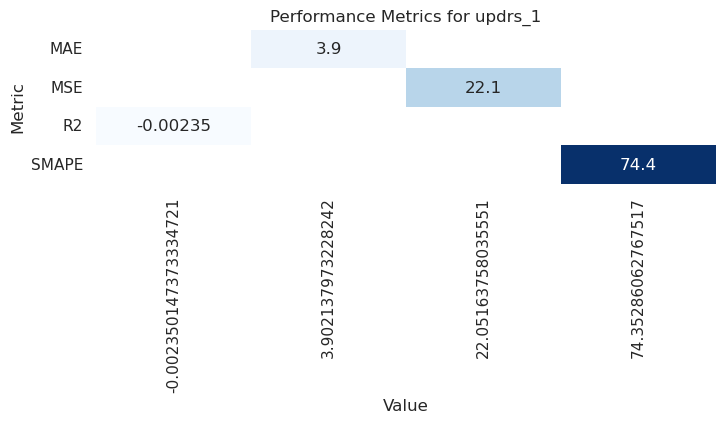

In [65]:
# Create a list of metric names and values.
metric_names = ['MSE', 'MAE', 'R2', 'SMAPE']
metric_values = [mse_updrs1, mae_updrs1, r2_updrs1, smape(y_test_updrs1, y_pred_updrs1)]

# Create a dataframe to hold the metric names and values.
df_metrics = pd.DataFrame({'Metric': metric_names, 'Value': metric_values})

# Create a heatmap to visualize the metrics.
sns.set_theme(style = "whitegrid")
fig, ax = plt.subplots(figsize = (8, 2))
sns.heatmap(df_metrics.pivot("Metric", "Value", "Value"), annot = True, fmt = ".3g", cmap = 'Blues', cbar = False)
plt.yticks(rotation = 0)
plt.title('Performance Metrics for updrs_1')
plt.show()

**Let's try cross-validation.**

In [66]:
from sklearn.model_selection import cross_val_score

# Separate the dataset for updrs_1.
df_updrs1 = df[['updrs_1'] + list(df.columns[4:])].dropna()

# Separate the independent variables (predictors) and the dependent variable (target).
X_updrs1 = df_updrs1.iloc[:, 1:]
y_updrs1 = df_updrs1.iloc[:, 0]

# Select the top 10 features with the highest F-values.
selector1 = SelectKBest(f_regression, k = 10)
X_new1 = selector1.fit_transform(X_updrs1, y_updrs1)

# Add visit_month column to X_new.
X_new1 = np.column_stack((df_updrs1.iloc[:, 1].values, X_new1))

# Standardize the independent variables.
scaler1 = StandardScaler()
X_new1 = scaler1.fit_transform(X_new1)

# Fit a linear regression model using cross-validation.
model_updrs1_cv = LinearRegression()
scores = cross_val_score(model_updrs1_cv, X_new1, y_updrs1, cv = 5)
r2_updrs1_cv = scores.mean()

# Print the mean squared error.
print("r2_updrs1_cv:", r2_updrs1_cv)

r2_updrs1_cv: -0.0053621517515126445


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:7: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  import sys


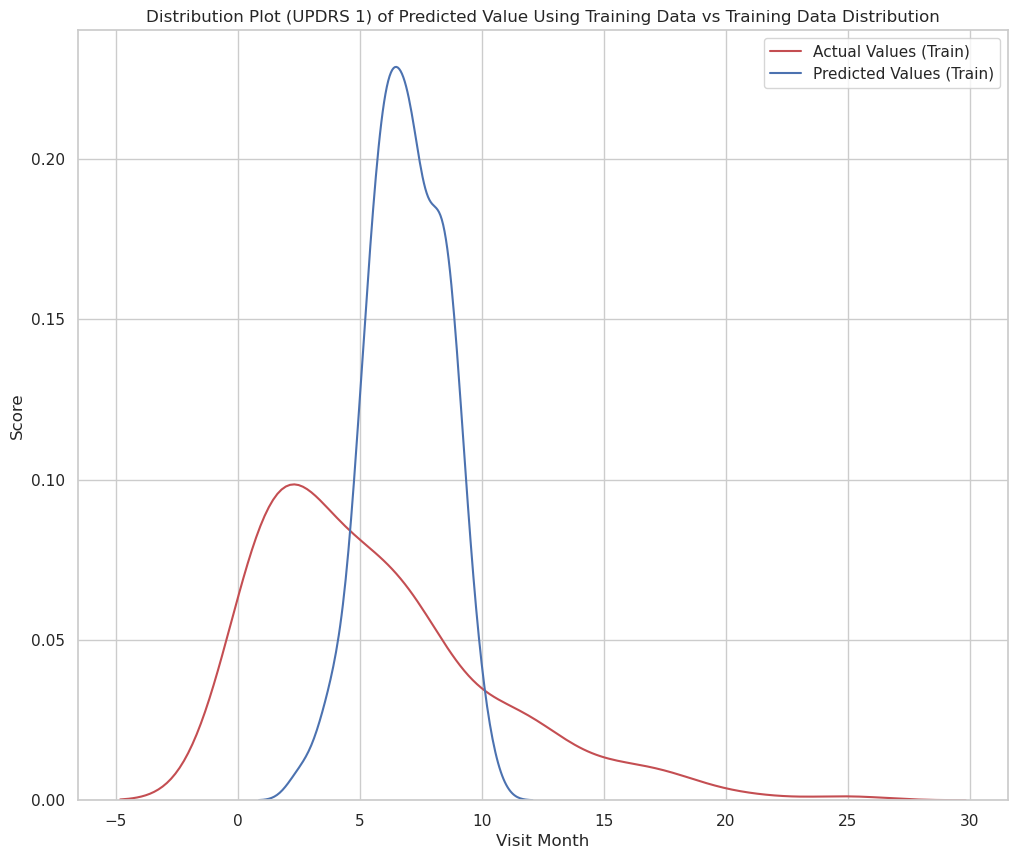

In [67]:
Title = 'Distribution Plot (UPDRS 1) of Predicted Value Using Training Data vs Training Data Distribution'
DistributionPlot(y_test_updrs1, y_pred_updrs1, "Actual Values (Train)", "Predicted Values (Train)", Title)

**We can repeat the above steps for predicting updrs_2, updrs_3, and updrs_4 by replacing the corresponding variable names.**

## updrs_2

In [68]:
# Separate the dataset for updrs_2.
df_updrs2 = df[['updrs_2'] + list(df.columns[4:])].dropna()

# Separate the independent variables (predictors) and the dependent variable (target).
X_updrs2 = df_updrs2.iloc[:, 1:]
y_updrs2 = df_updrs2.iloc[:, 0]

# Select the top 10 features based on the F-test score.
selector2 = SelectKBest(score_func = f_regression, k = 10)

# Fit the selector on the independent variables and target variable.
X_new2 = selector2.fit_transform(X_updrs2, y_updrs2)

# Get the indices of the selected features.
selected_indices2 = selector2.get_support(indices = True)

# Get the names of the selected features.
selected_X_updrs2 = X_updrs2.columns[selected_indices2]

In [69]:
# The selected features does not include visit_month.
selected_X_updrs2

Index(['ALEYIENLR', 'AYQGVAAPFPK', 'EAEEETTNDNGVLVLEPARK',
       'FIYGGC(UniMod_4)GGNR', 'GATLALTQVTPQDER', 'LDEVKEQVAEVR', 'LEEQAQQIR',
       'LQAEAFQAR', 'QQETAAAETETR', 'TLKIENVSYQDKGNYR'],
      dtype='object')

In [70]:
# Separate the dataset for updrs_2.
df_updrs2 = df[['updrs_2'] + list(df.columns[4:])].dropna()

# Separate the independent variables (predictors) and the dependent variable (target).
X_updrs2 = df_updrs2.iloc[:, 1:]
y_updrs2 = df_updrs2.iloc[:, 0]

# Select the top 10 features with the highest F-values.
selector2 = SelectKBest(f_regression, k = 10)
X_new2 = selector2.fit_transform(X_updrs2, y_updrs2)

# Add visit_month column to X_new.
X_new2 = np.column_stack((df_updrs2.iloc[:, 1].values, X_new2))

# Split the dataset into training and testing sets.
X_train_updrs2, X_test_updrs2, y_train_updrs2, y_test_updrs2 = train_test_split(X_new2, y_updrs2, test_size = 0.2, random_state = 42)

# Standardize the independent variables.
scaler2 = StandardScaler()
X_train_updrs2 = scaler2.fit_transform(X_train_updrs2)
X_test_updrs2 = scaler2.transform(X_test_updrs2)

# Fit a linear regression model on the training set.
model_updrs2 = LinearRegression()
model_updrs2.fit(X_train_updrs2, y_train_updrs2)

# Predict the values of the dependent variable (target) on the testing set.
y_pred_updrs2 = model_updrs2.predict(X_test_updrs2)
y_pred_updrs2 = np.where(y_pred_updrs2 < 0, 0, y_pred_updrs2)

# Evaluate the performance of the model.
mse_updrs2 = mean_squared_error(y_test_updrs2, y_pred_updrs2)
mae_updrs2 = mean_absolute_error(y_test_updrs2, y_pred_updrs2)
r2_updrs2 = r2_score(y_test_updrs2, y_pred_updrs2)

# mean squared error, mean absolute error, r2 score, and SMAPE for updrs_2
print("mse_updrs2:", mse_updrs2)
print("mae_updrs2:", mae_updrs2)
print("r2_updrs2:", r2_updrs2)
print("SMAPE_updrs2:", smape(y_test_updrs2, y_pred_updrs2))

mse_updrs2: 34.776305557241386
mae_updrs2: 4.7469689955003425
r2_updrs2: 0.023083795042578625
SMAPE_updrs2: 102.00374526264524


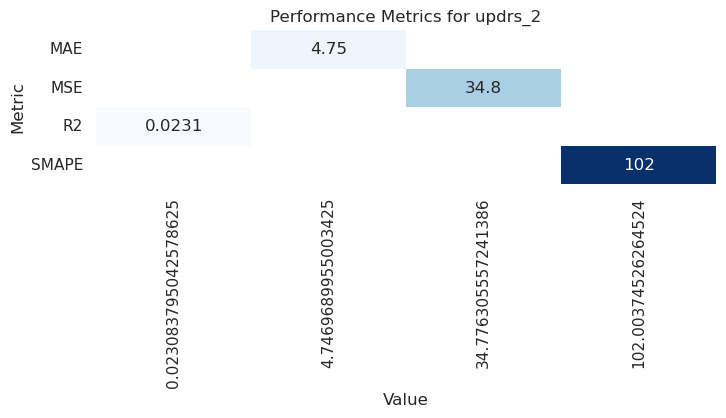

In [71]:
# Create a list of metric names and values.
metric_names = ['MSE', 'MAE', 'R2', 'SMAPE']
metric_values = [mse_updrs2, mae_updrs2, r2_updrs2, smape(y_test_updrs2, y_pred_updrs2)]

# Create a dataframe to hold the metric names and values.
df_metrics = pd.DataFrame({'Metric': metric_names, 'Value': metric_values})

# Create a heatmap to visualize the metrics.
sns.set_theme(style = "whitegrid")
fig, ax = plt.subplots(figsize = (8, 2))
sns.heatmap(df_metrics.pivot("Metric", "Value", "Value"), annot = True, fmt = ".3g", cmap = 'Blues', cbar = False)
plt.yticks(rotation = 0)
plt.title('Performance Metrics for updrs_2')
plt.show()

**Let's try cross-validation.**

In [72]:
# Separate the dataset for updrs_2.
df_updrs2 = df[['updrs_2'] + list(df.columns[4:])].dropna()

# Separate the independent variables (predictors) and the dependent variable (target).
X_updrs2 = df_updrs2.iloc[:, 1:]
y_updrs2 = df_updrs2.iloc[:, 0]

# Select the top 10 features with the highest F-values.
selector2 = SelectKBest(f_regression, k = 10)
X_new2 = selector2.fit_transform(X_updrs2, y_updrs2)

# Add visit_month column to X_new.
X_new2 = np.column_stack((df_updrs2.iloc[:, 1].values, X_new2))

# Standardize the independent variables.
scaler2 = StandardScaler()
X_new2 = scaler2.fit_transform(X_new2)

# Fit a linear regression model using cross-validation.
model_updrs2_cv = LinearRegression()
scores = cross_val_score(model_updrs2_cv, X_new2, y_updrs2, cv = 5)
r2_updrs2_cv = scores.mean()

# Print the mean squared error.
print("r2_updrs2_cv:", r2_updrs2_cv)

r2_updrs2_cv: 0.004342640360912942


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:7: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  import sys


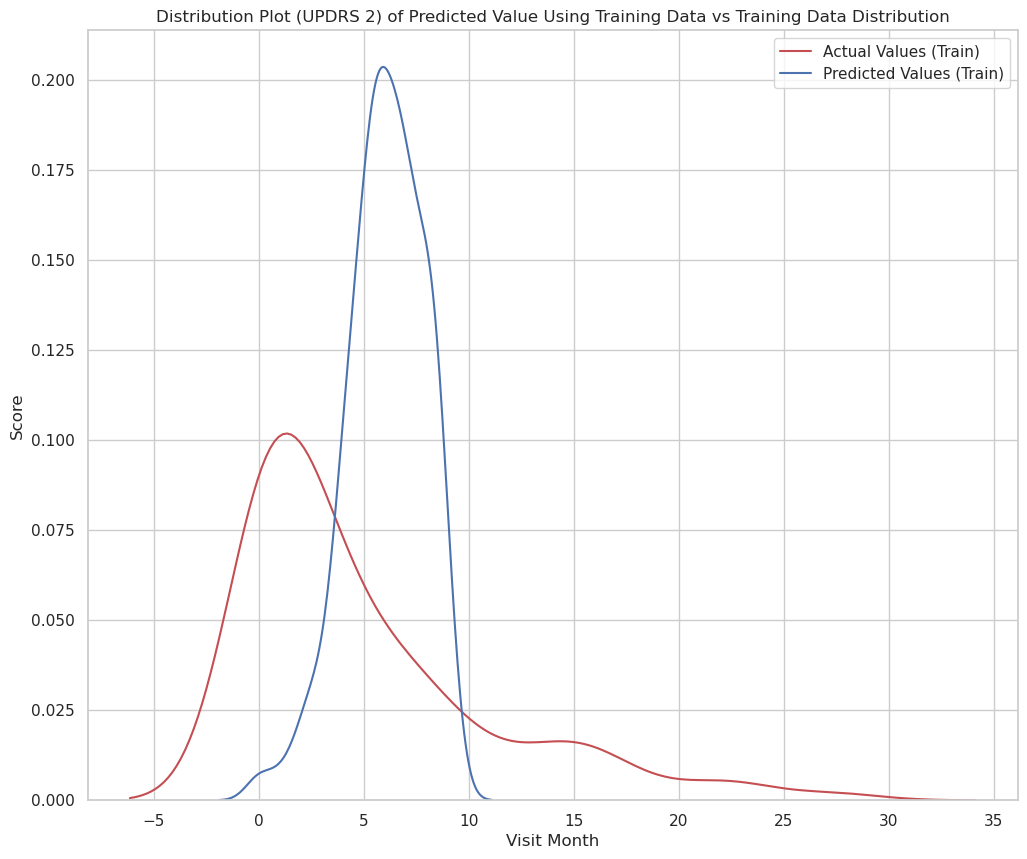

In [73]:
Title = 'Distribution Plot (UPDRS 2) of Predicted Value Using Training Data vs Training Data Distribution'
DistributionPlot(y_test_updrs2, y_pred_updrs2, "Actual Values (Train)", "Predicted Values (Train)", Title)

## updrs_3

In [74]:
# Separate the dataset for updrs_3.
df_updrs3 = df[['updrs_3'] + list(df.columns[4:])].dropna()

# Separate the independent variables (predictors) and the dependent variable (target).
X_updrs3 = df_updrs3.iloc[:, 1:]
y_updrs3 = df_updrs3.iloc[:, 0]

# Select the top 10 features based on the F-test score.
selector3 = SelectKBest(score_func = f_regression, k = 10)

# Fit the selector on the independent variables and target variable.
X_new3 = selector3.fit_transform(X_updrs3, y_updrs3)

# Get the indices of the selected features.
selected_indices3 = selector3.get_support(indices = True)

# Get the names of the selected features.
selected_X_updrs3 = X_updrs3.columns[selected_indices3]

In [75]:
# The selected features does not include visit_month.
selected_X_updrs3

Index(['ALEYIENLR', 'AYQGVAAPFPK', 'FVEGLPINDFSR', 'IEIPSSVQQVPTIIK',
       'KPQSAVYSTGSNGILLC(UniMod_4)EAEGEPQPTIK', 'LVFFAEDVGSNK',
       'QQETAAAETETR', 'TLKIENVSYQDKGNYR', 'VNGSPVDNHPFAGDVVFPR',
       'VRQGQGQSEPGEYEQR'],
      dtype='object')

In [76]:
# Separate the dataset for updrs_3.
df_updrs3 = df[['updrs_3'] + list(df.columns[4:])].dropna()

# Separate the independent variables (predictors) and the dependent variable (target).
X_updrs3 = df_updrs3.iloc[:, 1:]
y_updrs3 = df_updrs3.iloc[:, 0]

# Select the top 10 features with the highest F-values.
selector3 = SelectKBest(f_regression, k = 10)
X_new3 = selector3.fit_transform(X_updrs3, y_updrs3)

# Add visit_month column to X_new.
X_new3 = np.column_stack((df_updrs3.iloc[:, 1].values, X_new3))

# Split the dataset into training and testing sets.
X_train_updrs3, X_test_updrs3, y_train_updrs3, y_test_updrs3 = train_test_split(X_new3, y_updrs3, test_size = 0.2, random_state = 42)

# Standardize the independent variables.
scaler3 = StandardScaler()
X_train_updrs3 = scaler3.fit_transform(X_train_updrs3)
X_test_updrs3 = scaler3.transform(X_test_updrs3)

# Fit a linear regression model on the training set.
model_updrs3 = LinearRegression()
model_updrs3.fit(X_train_updrs3, y_train_updrs3)

# Predict the values of the dependent variable (target) on the testing set.
y_pred_updrs3 = model_updrs3.predict(X_test_updrs3)
y_pred_updrs3 = np.where(y_pred_updrs3 < 0, 0, y_pred_updrs3)

# Evaluate the performance of the model.
mse_updrs3 = mean_squared_error(y_test_updrs3, y_pred_updrs3)
mae_updrs3 = mean_absolute_error(y_test_updrs3, y_pred_updrs3)
r2_updrs3 = r2_score(y_test_updrs3, y_pred_updrs3)

# mean squared error, mean absolute error, r2 score, and SMAPE for updrs_3
print("mse_updrs3:", mse_updrs3)
print("mae_updrs3:", mae_updrs3)
print("r2_updrs3:", r2_updrs3)
print("SMAPE_updrs3:", smape(y_test_updrs3, y_pred_updrs3))

mse_updrs3: 237.37987149995837
mae_updrs3: 12.838956355508547
r2_updrs3: 0.04460050457442155
SMAPE_updrs3: 96.61876410425539


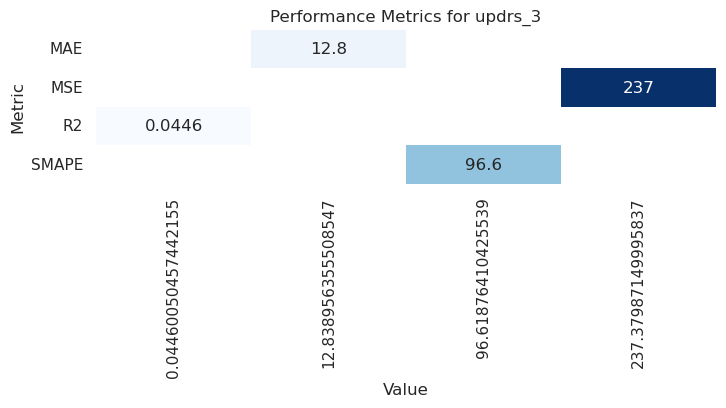

In [77]:
# Create a list of metric names and values.
metric_names = ['MSE', 'MAE', 'R2', 'SMAPE']
metric_values = [mse_updrs3, mae_updrs3, r2_updrs3, smape(y_test_updrs3, y_pred_updrs3)]

# Create a dataframe to hold the metric names and values.
df_metrics = pd.DataFrame({'Metric': metric_names, 'Value': metric_values})

# Create a heatmap to visualize the metrics.
sns.set_theme(style = "whitegrid")
fig, ax = plt.subplots(figsize = (8, 2))
sns.heatmap(df_metrics.pivot("Metric", "Value", "Value"), annot = True, fmt = ".3g", cmap = 'Blues', cbar = False)
plt.yticks(rotation = 0)
plt.title('Performance Metrics for updrs_3')
plt.show()

**Let's try cross-validation.**

In [78]:
# Separate the dataset for updrs_3.
df_updrs3 = df[['updrs_3'] + list(df.columns[4:])].dropna()

# Separate the independent variables (predictors) and the dependent variable (target).
X_updrs3 = df_updrs3.iloc[:, 1:]
y_updrs3 = df_updrs3.iloc[:, 0]

# Select the top 10 features with the highest F-values.
selector3 = SelectKBest(f_regression, k = 10)
X_new3 = selector3.fit_transform(X_updrs3, y_updrs3)

# Add visit_month column to X_new.
X_new3 = np.column_stack((df_updrs3.iloc[:, 1].values, X_new3))

# Standardize the independent variables.
scaler3 = StandardScaler()
X_new3 = scaler3.fit_transform(X_new3)

# Fit a linear regression model using cross-validation.
model_updrs3_cv = LinearRegression()
scores = cross_val_score(model_updrs3_cv, X_new3, y_updrs3, cv = 5)
r2_updrs3_cv = scores.mean()

# Print the mean squared error.
print("r2_updrs3_cv:", r2_updrs3_cv)

r2_updrs3_cv: 0.0371763009517724


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:7: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  import sys


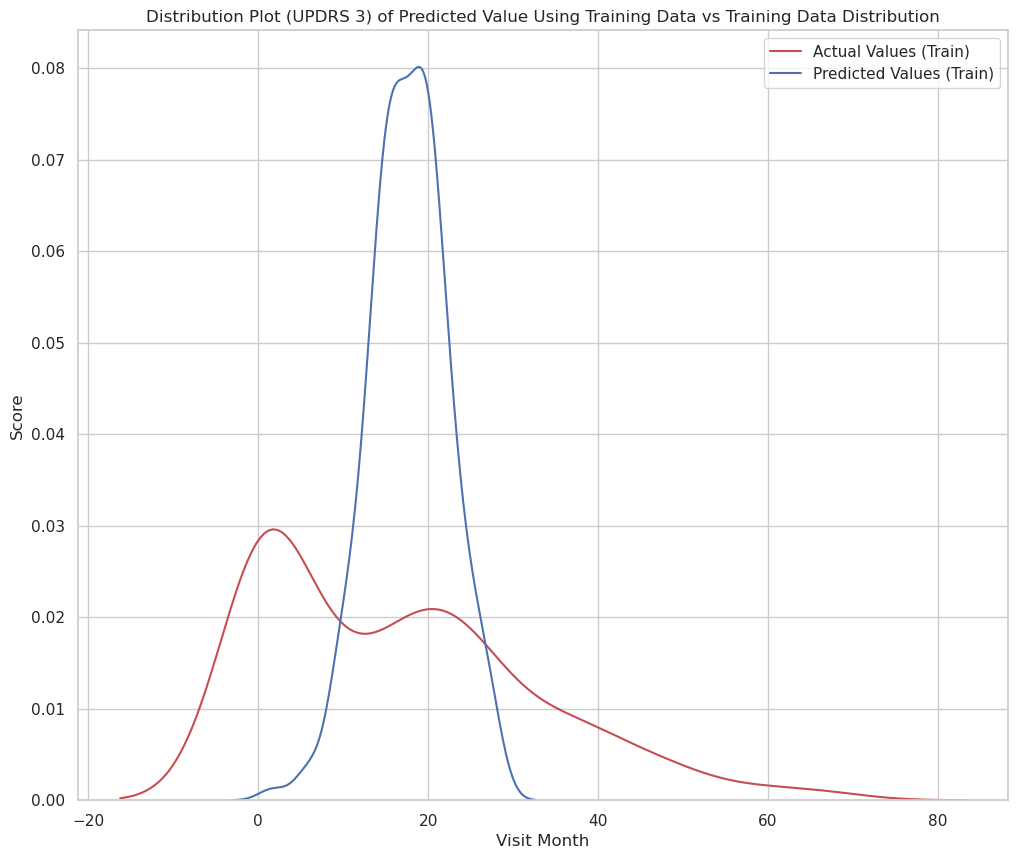

In [79]:
Title = 'Distribution Plot (UPDRS 3) of Predicted Value Using Training Data vs Training Data Distribution'
DistributionPlot(y_test_updrs3, y_pred_updrs3, "Actual Values (Train)", "Predicted Values (Train)", Title)

## updrs_4

In [80]:
# Separate the dataset for updrs_4.
df_updrs4 = df[['updrs_4'] + list(df.columns[4:])].dropna()

# Separate the independent variables (predictors) and the dependent variable (target).
X_updrs4 = df_updrs4.iloc[:, 1:]
y_updrs4 = df_updrs4.iloc[:, 0]

# Select the top 10 features based on the F-test score.
selector4 = SelectKBest(score_func = f_regression, k = 10)

# Fit the selector on the independent variables and target variable.
X_new4 = selector4.fit_transform(X_updrs4, y_updrs4)

# Get the indices of the selected features.
selected_indices4 = selector4.get_support(indices = True)

# Get the names of the selected features.
selected_X_updrs4 = X_updrs4.columns[selected_indices4]

In [81]:
# The selected features does not include visit_month.
selected_X_updrs4

Index(['APLIPMEHC(UniMod_4)TTR', 'C(UniMod_4)AEENC(UniMod_4)FIQK',
       'C(UniMod_4)PFPSRPDNGFVNYPAKPTLYYK', 'DYFMPC(UniMod_4)PGR',
       'EDC(UniMod_4)NELPPRR', 'FSGSLLGGK', 'LDEVKEQVAEVR', 'LLELTGPK',
       'SILENLR', 'VLEPTLK'],
      dtype='object')

In [82]:
# Separate the dataset for updrs_4.
df_updrs4 = df[['updrs_4'] + list(df.columns[4:])].dropna()

# Separate the independent variables (predictors) and the dependent variable (target).
X_updrs4 = df_updrs4.iloc[:, 1:]
y_updrs4 = df_updrs4.iloc[:, 0]

# Select the top 10 features with the highest F-values.
selector4 = SelectKBest(f_regression, k = 10)
X_new4 = selector4.fit_transform(X_updrs4, y_updrs4)

# Add visit_month column to X_new.
X_new4 = np.column_stack((df_updrs4.iloc[:, 1].values, X_new4))

# Split the dataset into training and testing sets.
X_train_updrs4, X_test_updrs4, y_train_updrs4, y_test_updrs4 = train_test_split(X_new4, y_updrs4, test_size = 0.2, random_state = 42)

# Standardize the independent variables.
scaler4 = StandardScaler()
X_train_updrs4 = scaler4.fit_transform(X_train_updrs4)
X_test_updrs4 = scaler4.transform(X_test_updrs4)

# Fit a linear regression model on the training set.
model_updrs4 = LinearRegression()
model_updrs4.fit(X_train_updrs4, y_train_updrs4)

# Predict the values of the dependent variable (target) on the testing set.
y_pred_updrs4 = model_updrs4.predict(X_test_updrs4)
y_pred_updrs4 = np.where(y_pred_updrs4 < 0, 0, y_pred_updrs4)

# Evaluate the performance of the model.
mse_updrs4 = mean_squared_error(y_test_updrs4, y_pred_updrs4)
mae_updrs4 = mean_absolute_error(y_test_updrs4, y_pred_updrs4)
r2_updrs4 = r2_score(y_test_updrs4, y_pred_updrs4)

# mean squared error, mean absolute error, r2 score, and SMAPE for updrs_4
print("mse_updrs4:", mse_updrs4)
print("mae_updrs4:", mae_updrs4)
print("r2_updrs4:", r2_updrs4)
print("SMAPE_updrs4:", smape(y_test_updrs4, y_pred_updrs4))

mse_updrs4: 7.59913669728573
mae_updrs4: 2.134560687492701
r2_updrs4: -0.029279935360716047
SMAPE_updrs4: 148.9579158475508


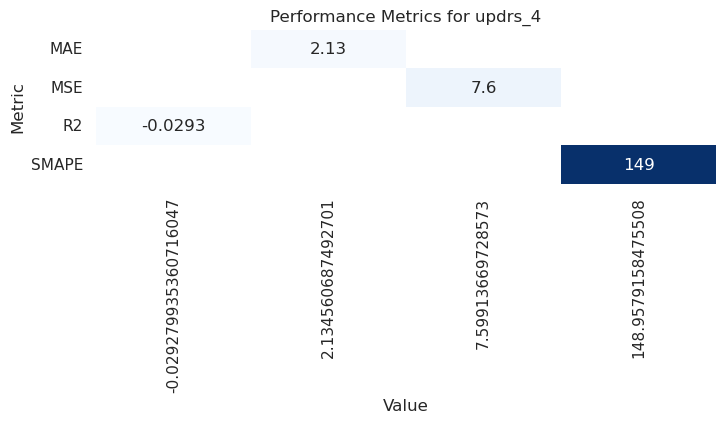

In [83]:
# Create a list of metric names and values.
metric_names = ['MSE', 'MAE', 'R2', 'SMAPE']
metric_values = [mse_updrs4, mae_updrs4, r2_updrs4, smape(y_test_updrs4, y_pred_updrs4)]

# Create a dataframe to hold the metric names and values.
df_metrics = pd.DataFrame({'Metric': metric_names, 'Value': metric_values})

# Create a heatmap to visualize the metrics.
sns.set_theme(style = "whitegrid")
fig, ax = plt.subplots(figsize = (8, 2))
sns.heatmap(df_metrics.pivot("Metric", "Value", "Value"), annot = True, fmt = ".3g", cmap = 'Blues', cbar = False)
plt.yticks(rotation = 0)
plt.title('Performance Metrics for updrs_4')
plt.show()

**Let's try cross-validation.**

In [84]:
# Separate the dataset for updrs_4.
df_updrs4 = df[['updrs_4'] + list(df.columns[4:])].dropna()

# Separate the independent variables (predictors) and the dependent variable (target).
X_updrs4 = df_updrs4.iloc[:, 1:]
y_updrs4 = df_updrs4.iloc[:, 0]

# Select the top 10 features with the highest F-values.
selector4 = SelectKBest(f_regression, k = 10)
X_new4 = selector4.fit_transform(X_updrs4, y_updrs4)

# Add visit_month column to X_new.
X_new4 = np.column_stack((df_updrs4.iloc[:, 1].values, X_new4))

# Standardize the independent variables.
scaler4 = StandardScaler()
X_new4 = scaler4.fit_transform(X_new4)

# Fit a linear regression model using cross-validation.
model_updrs4_cv = LinearRegression()
scores = cross_val_score(model_updrs4_cv, X_new4, y_updrs4, cv = 5)
r2_updrs4_cv = scores.mean()

# Print the mean squared error.
print("r2_updrs4_cv:", r2_updrs4_cv)

r2_updrs4_cv: -0.029569199136309555


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:7: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  import sys


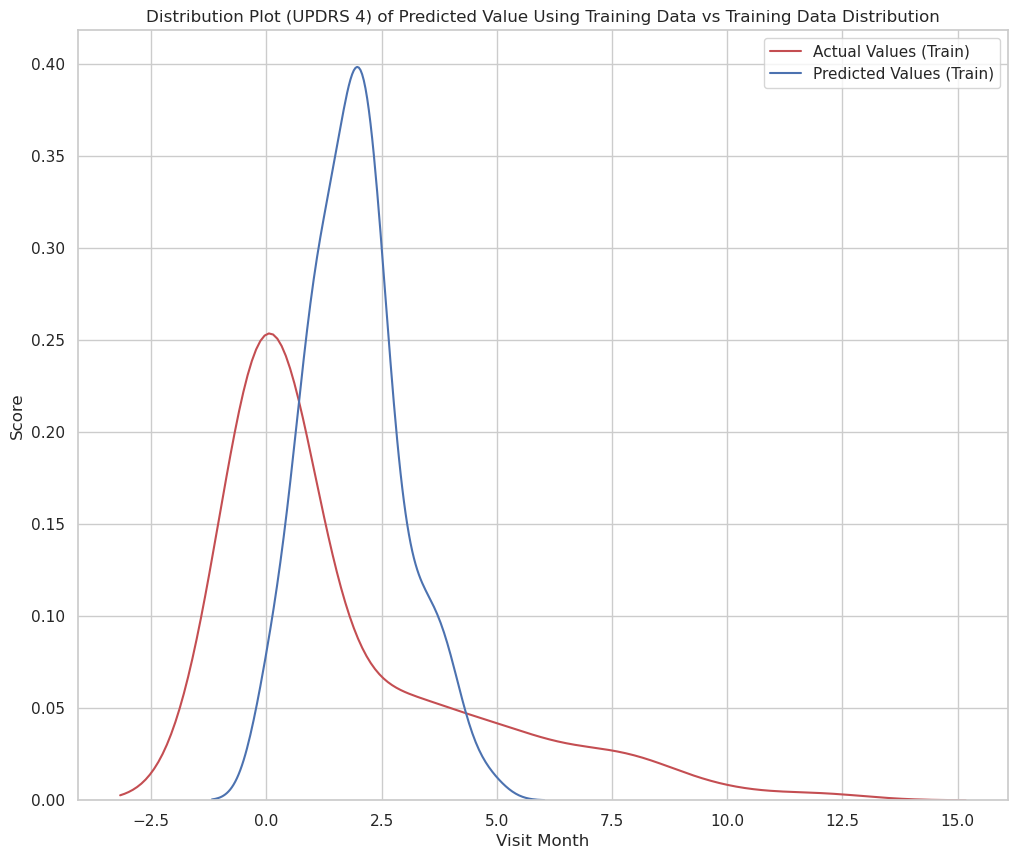

In [85]:
Title = 'Distribution Plot (UPDRS 4) of Predicted Value Using Training Data vs Training Data Distribution'
DistributionPlot(y_test_updrs4, y_pred_updrs4, "Actual Values (Train)", "Predicted Values (Train)", Title)

## Results

In [86]:
# Add a title to the DataFrame.
print("The Results with Univariate Feature Selection")

# Create a dictionary with the metrics for each target.
metrics_dict_KBest = {
    'Target': ['UPDRS 1', 'UPDRS 2', 'UPDRS 3', 'UPDRS 4'],
    'MSE': [mse_updrs1, mse_updrs2, mse_updrs3, mse_updrs4],
    'MAE': [mae_updrs1, mae_updrs2, mae_updrs3, mae_updrs4],
    'R2': [r2_updrs1, r2_updrs2, r2_updrs3, r2_updrs4],
    'SMAPE': [smape(y_test_updrs1, y_pred_updrs1), smape(y_test_updrs2, y_pred_updrs2), 
              smape(y_test_updrs3, y_pred_updrs3), smape(y_test_updrs4, y_pred_updrs4)]
}

# Create a Pandas DataFrame from the dictionary.
metrics_df_KBest = pd.DataFrame(metrics_dict_KBest)

# Set the 'Target' column as the index.
metrics_df_KBest.set_index('Target', inplace = True)

# Display the DataFrame.
metrics_df_KBest

The Results with Univariate Feature Selection


,MSE,MAE,R2,SMAPE
Target,,,,
UPDRS 1,22.051638,3.902138,-0.002350,74.352861
UPDRS 2,34.776306,4.746969,0.023084,102.003745
UPDRS 3,237.379871,12.838956,0.044601,96.618764
UPDRS 4,7.599137,2.134561,-0.029280,148.957916


In [87]:
# Add a title to the DataFrame.
print("The Results with Univariate Feature Selection and Cross-Validation")

# Create a dictionary with the metrics for each target.
metrics_dict_KBestCV = {
    'Target': ['UPDRS 1', 'UPDRS 2', 'UPDRS 3', 'UPDRS 4'],
    'R2': [r2_updrs1_cv, r2_updrs2_cv, r2_updrs3_cv, r2_updrs4_cv],
}

# Create a Pandas DataFrame from the dictionary.
metrics_df_KBestCV = pd.DataFrame(metrics_dict_KBestCV)

# Set the 'Target' column as the index.
metrics_df_KBestCV.set_index('Target', inplace = True)

# Display the DataFrame.
metrics_df_KBestCV

The Results with Univariate Feature Selection and Cross-Validation


,R2
Target,
UPDRS 1,-0.005362
UPDRS 2,0.004343
UPDRS 3,0.037176
UPDRS 4,-0.029569


# Inference with Test Data

In [88]:
# Copy sample_submission
answer = sample_submission.copy()
answer

,prediction_id,rating,group_key,patient_id,updrs,visit_month
0,3342_0_updrs_1_plus_0_months,0,0,3342,1,0
1,3342_0_updrs_1_plus_6_months,0,0,3342,1,6
2,3342_0_updrs_1_plus_12_months,0,0,3342,1,12
3,3342_0_updrs_1_plus_24_months,0,0,3342,1,24
4,3342_0_updrs_2_plus_0_months,0,0,3342,2,0
...,...,...,...,...,...,...
59,50423_6_updrs_3_plus_24_months,0,6,50423,3,24
60,50423_6_updrs_4_plus_0_months,0,6,50423,4,0
61,50423_6_updrs_4_plus_6_months,0,6,50423,4,6
62,50423_6_updrs_4_plus_12_months,0,6,50423,4,12


In [89]:
for i in range(len(test_df)):
    if int(test_df['prediction_id'][i].split('_')[3]) == 1:
        
        # Get the indices of the selected features.
        selected_indices1 = selector1.get_support(indices = True)

        # Get the names of the selected features.
        selected_X_updrs1 = X_updrs1.columns[selected_indices1]
        
        # Get the indexes for the dataset for updrs_1.
        common_indexes1 = [i for i, val in enumerate(test_df.columns.values) if val in selected_X_updrs1.values]
        common_indexes1.insert(0, 5)
        
        # Separate the dataset for updrs_1.
        test_df_updrs1 = np.array(list(test_df.iloc[i, common_indexes1]))
        
        # Standardize the independent variables.
        test_df_updrs1 = test_df_updrs1.reshape(1, -1)
        scaler_test1 = StandardScaler()
        scaler_test1.fit(test_df_updrs1)
        test_df_updrs1 = scaler_test1.transform(test_df_updrs1)
        
        # Predict the values of the dependent variable (target) on the testing set.
        test_df_pred_updrs1 = model_updrs1.predict(test_df_updrs1)
        if test_df_pred_updrs1 < 0:
            test_df_pred_updrs1 = 0
        answer.loc[i, 'rating'] = np.round(test_df_pred_updrs1, 0)
        
    elif int(test_df['prediction_id'][i].split('_')[3]) == 2:
        
        # Get the indices of the selected features.
        selected_indices2 = selector2.get_support(indices = True)

        # Get the names of the selected features.
        selected_X_updrs2 = X_updrs2.columns[selected_indices2]
        
        # Get the indexes for the dataset for updrs_2.
        common_indexes2 = [i for i, val in enumerate(test_df.columns.values) if val in selected_X_updrs2.values]
        common_indexes2.insert(0, 5)
        
        # Separate the dataset for updrs_2.
        test_df_updrs2 = np.array(list(test_df.iloc[i, common_indexes2]))
        
        # Standardize the independent variables.
        test_df_updrs2 = test_df_updrs2.reshape(1, -1)
        scaler_test2 = StandardScaler()
        scaler_test2.fit(test_df_updrs2)
        test_df_updrs2 = scaler_test2.transform(test_df_updrs2)
        
        # Predict the values of the dependent variable (target) on the testing set.
        test_df_pred_updrs2 = model_updrs2.predict(test_df_updrs2)
        if test_df_pred_updrs2 < 0:
            test_df_pred_updrs2 = 0
        answer.loc[i, 'rating'] = np.round(test_df_pred_updrs2, 0)
        
    elif int(test_df['prediction_id'][i].split('_')[3]) == 3:
        
        # Get the indices of the selected features.
        selected_indices3 = selector3.get_support(indices = True)

        # Get the names of the selected features.
        selected_X_updrs3 = X_updrs3.columns[selected_indices3]
        
        # Get the indexes for the dataset for updrs_3.
        common_indexes3 = [i for i, val in enumerate(test_df.columns.values) if val in selected_X_updrs3.values]
        common_indexes3.insert(0, 5)
        
        # Separate the dataset for updrs_3.
        test_df_updrs3 = np.array(list(test_df.iloc[i, common_indexes3]))
        
        # Standardize the independent variables.
        test_df_updrs3 = test_df_updrs3.reshape(1, -1)
        scaler_test3 = StandardScaler()
        scaler_test3.fit(test_df_updrs3)
        test_df_updrs3 = scaler_test3.transform(test_df_updrs3)
        
        # Predict the values of the dependent variable (target) on the testing set.
        test_df_pred_updrs3 = model_updrs3.predict(test_df_updrs3)
        if test_df_pred_updrs3 < 0:
            test_df_pred_updrs3 = 0
        answer.loc[i, 'rating'] = np.round(test_df_pred_updrs3, 0)
        
    else:
        
        # Get the indices of the selected features.
        selected_indices4 = selector4.get_support(indices = True)

        # Get the names of the selected features.
        selected_X_updrs4 = X_updrs4.columns[selected_indices4]
        
        # Get the indexes for the dataset for updrs_4.
        common_indexes4 = [i for i, val in enumerate(test_df.columns.values) if val in selected_X_updrs4.values]
        common_indexes4.insert(0, 5)
        
        # Separate the dataset for updrs_4.
        test_df_updrs4 = np.array(list(test_df.iloc[i, common_indexes4]))
        
        # Standardize the independent variables.
        test_df_updrs4 = test_df_updrs4.reshape(1, -1)
        scaler_test4 = StandardScaler()
        scaler_test4.fit(test_df_updrs4)
        test_df_updrs4 = scaler_test4.transform(test_df_updrs4)
        
        # Predict the values of the dependent variable (target) on the testing set.
        test_df_pred_updrs4 = model_updrs4.predict(test_df_updrs4)
        if test_df_pred_updrs4 < 0:
            test_df_pred_updrs4 = 0
        answer.loc[i, 'rating'] = np.round(test_df_pred_updrs4, 0)
        answer.loc[i, 'rating'] = 0
    
answer

,prediction_id,rating,group_key,patient_id,updrs,visit_month
0,3342_0_updrs_1_plus_0_months,7,0,3342,1,0
1,3342_0_updrs_1_plus_6_months,7,0,3342,1,6
2,3342_0_updrs_1_plus_12_months,7,0,3342,1,12
3,3342_0_updrs_1_plus_24_months,7,0,3342,1,24
4,3342_0_updrs_2_plus_0_months,6,0,3342,2,0
...,...,...,...,...,...,...
59,50423_6_updrs_3_plus_24_months,18,6,50423,3,24
60,50423_6_updrs_4_plus_0_months,0,6,50423,4,0
61,50423_6_updrs_4_plus_6_months,0,6,50423,4,6
62,50423_6_updrs_4_plus_12_months,0,6,50423,4,12


In [90]:
answer = answer.iloc[:, :2]
answer

,prediction_id,rating
0,3342_0_updrs_1_plus_0_months,7
1,3342_0_updrs_1_plus_6_months,7
2,3342_0_updrs_1_plus_12_months,7
3,3342_0_updrs_1_plus_24_months,7
4,3342_0_updrs_2_plus_0_months,6
...,...,...
59,50423_6_updrs_3_plus_24_months,18
60,50423_6_updrs_4_plus_0_months,0
61,50423_6_updrs_4_plus_6_months,0
62,50423_6_updrs_4_plus_12_months,0


# Submission

**For Submission, we have to re-create a special code like below. This is a sort of summary of the code above.**

In [91]:
proteins = pd.read_csv('/kaggle/input/amp-parkinsons-disease-progression-prediction/train_proteins.csv')
print('Proteins shape:',proteins.shape)

Proteins shape: (232741, 5)


In [92]:
peptides = pd.read_csv('/kaggle/input/amp-parkinsons-disease-progression-prediction/train_peptides.csv')
print('Peptides shape:', peptides.shape)

Peptides shape: (981834, 6)


In [93]:
clinical = pd.read_csv('/kaggle/input/amp-parkinsons-disease-progression-prediction/train_clinical_data.csv')
print('Clinical shape:', clinical.shape)

Clinical shape: (2615, 8)


In [94]:
def get_predictions(test, test_peptides, test_proteins, sample_submission):
    
    # Merge the proteins data and peptides data on the common columns.
    merged_proteins_peptides = pd.merge(proteins, peptides, on = ['visit_id', 'visit_month', 'patient_id', 'UniProt'])

    # Merge the merged protein-peptides data with the clinical data on the common columns.
    merged = pd.merge(merged_proteins_peptides, clinical, on = ['visit_id', 'visit_month', 'patient_id'])

    merged['Peptide / Protein'] = merged['PeptideAbundance'] / merged['NPX']
    merged

    # Pivot the data
    pivoted = merged.pivot(index = 'visit_id', columns = ['Peptide'], values = 'PeptideAbundance')

    # Add visit_month, the 4 scores, and medication status.
    df = pd.merge(clinical, pivoted, on = 'visit_id', how = 'right').set_index('visit_id')

    # Insert the visit_month column to the desired position.
    df.insert(6, 'visit_month', df.pop('visit_month'))

    df = df.drop('patient_id', axis = 1)

    # Replace NaN with 0 in the Peptides columns.
    df.loc[:, 'AADDTWEPFASGK':] = df.loc[:, 'AADDTWEPFASGK':].fillna(0)
        
    # Merge the proteins data and peptides data on the common columns.
    test_merged_proteins_peptides = pd.merge(test_proteins, test_peptides, on = ['visit_id', 'visit_month', 'patient_id', 'UniProt'])

    # Merge the merged protein-peptides data with the clinical data on the common columns.
    test_merged = pd.merge(test_merged_proteins_peptides, test, on = ['visit_id', 'visit_month', 'patient_id'])

    test_merged['prediction_id'] = test_merged.apply(lambda x: '{}_plus_{}months'.format(x['row_id'], x['visit_month']), axis = 1)

    test_merged['Peptide / Protein'] = test_merged['PeptideAbundance'] / test_merged['NPX']

    # Pivot the data
    test_pivoted = test_merged.pivot(index = 'prediction_id', columns = ['Peptide'], values = 'PeptideAbundance')

    # Replace NaN with 0 in the Peptides columns.
    test_pivoted.loc[:, 'AADDTWEPFASGK':] = test_pivoted.loc[:, 'AADDTWEPFASGK':].fillna(0)

    # We need to remove duplicates by patient_id.
    index_list = list(test_pivoted.index)
    patient_id = []
    for i in range(len(test_pivoted)):
        element = index_list[i].split('_')[0]
        patient_id.append(element)

    test_pivoted['patient_id'] = patient_id

    test_pivoted = test_pivoted.drop_duplicates(subset = 'patient_id')
    patient_id = test_pivoted.pop('patient_id')
    test_pivoted.insert(0, 'patient_id', patient_id)

    # We need to crate visit_month in sample submission.
    index_list = list(sample_submission.prediction_id)
    patient_id = []
    for i in range(len(sample_submission)):
        element = index_list[i].split('_')[0]
        patient_id.append(element)

    sample_submission['patient_id'] = patient_id

    # We need to crate updrs in sample submission.
    index_list = list(sample_submission.prediction_id)
    updrs = []
    for i in range(len(sample_submission)):
        element = index_list[i].split('_')[3]
        updrs.append(element)

    sample_submission['updrs'] = updrs

    # We need to crate patient_id in sample submission.
    index_list = list(sample_submission.prediction_id)
    visit_month = []
    for i in range(len(sample_submission)):
        element = index_list[i].split('_')[-2]
        visit_month.append(element)

    sample_submission['visit_month'] = visit_month

    # Merge the data and sample_submission, while keeping the order of rows of sample_submission.
    test_df = pd.merge(sample_submission, test_pivoted, on = ['patient_id'], how = 'left')

    # Drop upd23b_clinical_state_on_medication column from the previous merged train dataset df.
    df = df.drop('upd23b_clinical_state_on_medication', axis = 1)

    # If a peptide in the train dataset does not exist in the test dataset, remove it.
    remove_train = []
    for i in range(len(list(df.columns[5:].values))):
        if list(df.columns[5:].values)[i] not in list(test_df.columns[6:].values):
            remove_train.append(list(df.columns[5:].values)[i])

    df = df.drop(remove_train, axis = 1)
    
    # If a peptide in the test dataset does not exist in the train dataset, remove it.
    remove_test = []
    for i in range(len(list(test_df.columns[6:].values))):
        if list(test_df.columns[6:].values)[i] not in list(df.columns[5:].values):
            remove_test.append(list(test_df.columns[6:].values)[i])

    test_df = test_df.drop(remove_test, axis = 1)
    
    # Separate the dataset for updrs_1.
    df_updrs1 = df[['updrs_1'] + list(df.columns[4:])].dropna()

    # Separate the independent variables (predictors) and the dependent variable (target).
    X_updrs1 = df_updrs1.iloc[:, 1:]
    y_updrs1 = df_updrs1.iloc[:, 0]

    # Select the top 10 features with the highest F-values.
    selector1 = SelectKBest(f_regression, k = 10)
    X_new1 = selector1.fit_transform(X_updrs1, y_updrs1)

    # Add visit_month column to X_new.
    X_new1 = np.column_stack((df_updrs1.iloc[:, 1].values, X_new1))

    # Standardize the independent variables.
    scaler1 = StandardScaler()
    X_updrs1 = scaler1.fit_transform(X_new1)

    # Fit a linear regression model on the training set.
    model_updrs1 = LinearRegression()
    model_updrs1.fit(X_updrs1, y_updrs1)

    # Separate the dataset for updrs_2.
    df_updrs2 = df[['updrs_2'] + list(df.columns[4:])].dropna()

    # Separate the independent variables (predictors) and the dependent variable (target).
    X_updrs2 = df_updrs2.iloc[:, 1:]
    y_updrs2 = df_updrs2.iloc[:, 0]
    
    # Select the top 10 features with the highest F-values.
    selector2 = SelectKBest(f_regression, k = 10)
    X_new2 = selector2.fit_transform(X_updrs2, y_updrs2)

    # Add visit_month column to X_new.
    X_new2 = np.column_stack((df_updrs2.iloc[:, 1].values, X_new2))

    # Standardize the independent variables.
    scaler2 = StandardScaler()
    X_updrs2 = scaler2.fit_transform(X_new2)

    # Fit a linear regression model on the training set.
    model_updrs2 = LinearRegression()
    model_updrs2.fit(X_updrs2, y_updrs2)

    # Separate the dataset for updrs_3.
    df_updrs3 = df[['updrs_3'] + list(df.columns[4:])].dropna()

    # Separate the independent variables (predictors) and the dependent variable (target).
    X_updrs3 = df_updrs3.iloc[:, 1:]
    y_updrs3 = df_updrs3.iloc[:, 0]
    
    # Select the top 10 features with the highest F-values.
    selector3 = SelectKBest(f_regression, k = 10)
    X_new3 = selector3.fit_transform(X_updrs3, y_updrs3)

    # Add visit_month column to X_new.
    X_new3 = np.column_stack((df_updrs3.iloc[:, 1].values, X_new3))

    # Standardize the independent variables.
    scaler3 = StandardScaler()
    X_updrs3 = scaler3.fit_transform(X_new3)

    # Fit a linear regression model on the training set.
    model_updrs3 = LinearRegression()
    model_updrs3.fit(X_updrs3, y_updrs3)

    # Separate the dataset for updrs_4.
    df_updrs4 = df[['updrs_4'] + list(df.columns[4:])].dropna()

    # Separate the independent variables (predictors) and the dependent variable (target).
    X_updrs4 = df_updrs4.iloc[:, 1:]
    y_updrs4 = df_updrs4.iloc[:, 0]
    
    # Select the top 10 features with the highest F-values.
    selector4 = SelectKBest(f_regression, k = 10)
    X_new4 = selector4.fit_transform(X_updrs4, y_updrs4)

    # Add visit_month column to X_new.
    X_new4 = np.column_stack((df_updrs4.iloc[:, 1].values, X_new4))

    # Standardize the independent variables.
    scaler4 = StandardScaler()
    X_updrs4 = scaler4.fit_transform(X_new4)

    # Fit a linear regression model on the training set.
    model_updrs4 = LinearRegression()
    model_updrs4.fit(X_updrs4, y_updrs4)
    
    # Copy sample_submission
    answer = sample_submission.copy()
    answer

    for i in range(len(test_df)):
        
        if int(test_df['prediction_id'][i].split('_')[3]) == 1:

            # Get the indices of the selected features.
            selected_indices1 = selector1.get_support(indices = True)

            # Get the names of the selected features.
            selected_X_updrs1 = df.columns[4:][selected_indices1]

            # Get the indexes for the dataset for updrs_1.
            common_indexes1 = [i for i, val in enumerate(test_df.columns.values) if val in selected_X_updrs1.values]
            common_indexes1.insert(0, 5)

            # Separate the dataset for updrs_1.
            test_df_updrs1 = np.array(list(test_df.iloc[i, common_indexes1]))
            
            # Replace NaN values with 0.
            test_df_updrs1[np.isnan(test_df_updrs1)] = 0

            # Standardize the independent variables.
            test_df_updrs1 = test_df_updrs1.reshape(1, -1)
            scaler_test1 = StandardScaler()
            test_df_updrs1 = scaler_test1.fit_transform(test_df_updrs1)

            # Predict the values of the dependent variable (target) on the testing set.
            test_df_pred_updrs1 = model_updrs1.predict(test_df_updrs1)
            if test_df_pred_updrs1 < 0:
                test_df_pred_updrs1 = 0
            answer.loc[i, 'rating'] = np.round(test_df_pred_updrs1, 0)

        elif int(test_df['prediction_id'][i].split('_')[3]) == 2:

            # Get the indices of the selected features.
            selected_indices2 = selector2.get_support(indices = True)

            # Get the names of the selected features.
            selected_X_updrs2 = df.columns[4:][selected_indices2]

            # Get the indexes for the dataset for updrs_2.
            common_indexes2 = [i for i, val in enumerate(test_df.columns.values) if val in selected_X_updrs2.values]
            common_indexes2.insert(0, 5)

            # Separate the dataset for updrs_2.
            test_df_updrs2 = np.array(list(test_df.iloc[i, common_indexes2]))
            
            # Replace NaN values with 0.
            test_df_updrs2[np.isnan(test_df_updrs2)] = 0

            # Standardize the independent variables.
            test_df_updrs2 = test_df_updrs2.reshape(1, -1)
            scaler_test2 = StandardScaler()
            test_df_updrs2 = scaler_test2.fit_transform(test_df_updrs2)

            # Predict the values of the dependent variable (target) on the testing set.
            test_df_pred_updrs2 = model_updrs2.predict(test_df_updrs2)
            if test_df_pred_updrs2 < 0:
                test_df_pred_updrs2 = 0
            answer.loc[i, 'rating'] = np.round(test_df_pred_updrs2, 0)

        elif int(test_df['prediction_id'][i].split('_')[3]) == 3:

            # Get the indices of the selected features.
            selected_indices3 = selector3.get_support(indices = True)

            # Get the names of the selected features.
            selected_X_updrs3 = df.columns[4:][selected_indices3]

            # Get the indexes for the dataset for updrs_3.
            common_indexes3 = [i for i, val in enumerate(test_df.columns.values) if val in selected_X_updrs3.values]
            common_indexes3.insert(0, 5)

            # Separate the dataset for updrs_3.
            test_df_updrs3 = np.array(list(test_df.iloc[i, common_indexes3]))
            
            # Replace NaN values with 0.
            test_df_updrs3[np.isnan(test_df_updrs3)] = 0

            # Standardize the independent variables.
            test_df_updrs3 = test_df_updrs3.reshape(1, -1)
            scaler_test3 = StandardScaler()
            test_df_updrs3 = scaler_test3.fit_transform(test_df_updrs3)

            # Predict the values of the dependent variable (target) on the testing set.
            test_df_pred_updrs3 = model_updrs3.predict(test_df_updrs3)
            if test_df_pred_updrs3 < 0:
                test_df_pred_updrs3 = 0
            answer.loc[i, 'rating'] = np.round(test_df_pred_updrs3, 0)

        else:

            # Get the indices of the selected features.
            selected_indices4 = selector4.get_support(indices = True)

            # Get the names of the selected features.
            selected_X_updrs4 = df.columns[4:][selected_indices4]

            # Get the indexes for the dataset for updrs_4.
            common_indexes4 = [i for i, val in enumerate(test_df.columns.values) if val in selected_X_updrs4.values]
            common_indexes4.insert(0, 5)

            # Separate the dataset for updrs_4.
            test_df_updrs4 = np.array(list(test_df.iloc[i, common_indexes4]))
            
            # Replace NaN values with 0.
            test_df_updrs4[np.isnan(test_df_updrs4)] = 0

            # Standardize the independent variables.
            test_df_updrs4 = test_df_updrs4.reshape(1, -1)
            scaler_test4 = StandardScaler()
            test_df_updrs4 = scaler_test4.fit_transform(test_df_updrs4)
            
            # Predict the values of the dependent variable (target) on the testing set.
            test_df_pred_updrs4 = model_updrs4.predict(test_df_updrs4)
            if test_df_pred_updrs4 < 0:
                test_df_pred_updrs4 = 0
            answer.loc[i, 'rating'] = np.round(test_df_pred_updrs4, 0)
            answer.loc[i, 'rating'] = 0

    answer = answer.iloc[:, :2]

    return answer

In [95]:
import sys
sys.path.append('/kaggle/input/amp-pd')
import amp_pd_peptide

In [96]:
# Initialize the environment.
env = amp_pd_peptide.make_env()
iter_test = env.iter_test()

In [97]:
# Register the predictions.
for (test, test_peptides, test_proteins, sample_submission) in iter_test:

    result = get_predictions(test, test_peptides, test_proteins, sample_submission)
    
    if len(sample_submission) == len(result):
        sample_submission['rating'] = result['rating']
        
    elif len(sample_submission) < len(result):
        sample_submission['rating'] = result['rating'][0:len(sample_submission)]
        
    else:
        sample_submission['rating'][0:len(result)] = result['rating']
        
    sample_submission = sample_submission.iloc[:, 0:2]
    
    env.predict(sample_submission)

This version of the API is not optimized and should not be used to estimate the runtime of your code on the hidden test set.


In [98]:
print(sample_submission)

                     prediction_id  rating
0     3342_6_updrs_1_plus_0_months       7
1     3342_6_updrs_1_plus_6_months       7
2    3342_6_updrs_1_plus_12_months       7
3    3342_6_updrs_1_plus_24_months       7
4     3342_6_updrs_2_plus_0_months       6
5     3342_6_updrs_2_plus_6_months       6
6    3342_6_updrs_2_plus_12_months       6
7    3342_6_updrs_2_plus_24_months       6
8     3342_6_updrs_3_plus_0_months      17
9     3342_6_updrs_3_plus_6_months      17
10   3342_6_updrs_3_plus_12_months      17
11   3342_6_updrs_3_plus_24_months      17
12    3342_6_updrs_4_plus_0_months       0
13    3342_6_updrs_4_plus_6_months       0
14   3342_6_updrs_4_plus_12_months       0
15   3342_6_updrs_4_plus_24_months       0
16   50423_6_updrs_1_plus_0_months       7
17   50423_6_updrs_1_plus_6_months       7
18  50423_6_updrs_1_plus_12_months       7
19  50423_6_updrs_1_plus_24_months       7
20   50423_6_updrs_2_plus_0_months       6
21   50423_6_updrs_2_plus_6_months       6
22  50423_6

# Save, Load, and Use Model

To save the trained Linear Regression model, you can use the joblib library from the sklearn.externals module. This will save the model to a file called 'updrs1_model.sav' in the current working directory. **To load the saved model later**, we can use the joblib.load() function.

In [99]:
import joblib

# Save the model to disk.
filename = 'updrs1_model.sav'
joblib.dump(model_updrs1, filename)

# Load the model from disk.
loaded_model_1 = joblib.load(filename)

# Use the loaded model to make predictions.
y_pred_updrs1_loaded = loaded_model_1.predict(X_test_updrs1)

We save the other models as well.

In [100]:
# Save the model to disk.
filename = 'updrs2_model.sav'
joblib.dump(model_updrs2, filename)

# Load the model from disk.
loaded_model_2 = joblib.load(filename)

# Use the loaded model to make predictions.
y_pred_updrs2_loaded = loaded_model_2.predict(X_test_updrs2)

In [101]:
# Save the model to disk.
filename = 'updrs3_model.sav'
joblib.dump(model_updrs3, filename)

# Load the model from disk.
loaded_model_3 = joblib.load(filename)

# Use the loaded model to make predictions.
y_pred_updrs3_loaded = loaded_model_3.predict(X_test_updrs3)

In [102]:
# Save the model to disk.
filename = 'updrs4_model.sav'
joblib.dump(model_updrs4, filename)

# Load the model from disk.
loaded_model_4 = joblib.load(filename)

# Use the loaded model to make predictions.
y_pred_updrs4_loaded = loaded_model_4.predict(X_test_updrs4)

# Only Visit Month

Actually, **many people attempt to build a model only with 'visit_month' to get a high score**. In fact, this may be a better strategy.

In [103]:
# Read train CSV files.
train = pd.read_csv("/kaggle/input/amp-parkinsons-disease-progression-prediction/train_clinical_data.csv")
sup = pd.read_csv('/kaggle/input/amp-parkinsons-disease-progression-prediction/supplemental_clinical_data.csv')
train = train.append(sup, ignore_index = True)

# Create datasets.
train1 = train[['visit_month'] + ['updrs_1']].dropna()
train2 = train[['visit_month'] + ['updrs_2']].dropna()
train3 = train[['visit_month'] + ['updrs_3']].dropna()
train4 = train[['visit_month'] + ['updrs_4']].dropna()

x_data1 = train1['visit_month'].values.reshape(-1, 1)
x_data2 = train2['visit_month'].values.reshape(-1, 1)
x_data3 = train3['visit_month'].values.reshape(-1, 1)
x_data4 = train4['visit_month'].values.reshape(-1, 1)
y_data1 = train1['updrs_1']
y_data2 = train2['updrs_2']
y_data3 = train3['updrs_3']
y_data4 = train4['updrs_4']

# Split the dataset into training and testing sets.
x_train1, x_test1, y_train1, y_test1 = train_test_split(x_data1, y_data1, test_size = 0.2, random_state = 42)
x_train2, x_test2, y_train2, y_test2 = train_test_split(x_data2, y_data2, test_size = 0.2, random_state = 42)
x_train3, x_test3, y_train3, y_test3 = train_test_split(x_data3, y_data3, test_size = 0.2, random_state = 42)
x_train4, x_test4, y_train4, y_test4 = train_test_split(x_data4, y_data4, test_size = 0.2, random_state = 42)

In [104]:
# Fit a linear regression model on the training set.
model_updrs1 = LinearRegression()
model_updrs2 = LinearRegression()
model_updrs3 = LinearRegression()
model_updrs4 = LinearRegression()

model_updrs1.fit(x_train1, y_train1)
model_updrs2.fit(x_train2, y_train2)
model_updrs3.fit(x_train3, y_train3)
model_updrs4.fit(x_train4, y_train4)

# Predict the values of the dependent variable (target) on the testing set.
y_pred1 = model_updrs1.predict(x_test1)
y_pred1 = np.where(y_pred1 < 0, 0, y_pred1)
y_pred2 = model_updrs2.predict(x_test2)
y_pred2 = np.where(y_pred2 < 0, 0, y_pred2)
y_pred3 = model_updrs3.predict(x_test3)
y_pred3 = np.where(y_pred3 < 0, 0, y_pred3)
y_pred4 = model_updrs4.predict(x_test4)
y_pred4 = np.where(y_pred4 < 0, 0, y_pred4)

# Evaluate the performance of the model.
mse_updrs1 = mean_squared_error(y_test1, y_pred1)
mae_updrs1 = mean_absolute_error(y_test1, y_pred1)
r2_updrs1 = r2_score(y_test1, y_pred1)

mse_updrs2 = mean_squared_error(y_test2, y_pred2)
mae_updrs2 = mean_absolute_error(y_test2, y_pred2)
r2_updrs2 = r2_score(y_test2, y_pred2)

mse_updrs3 = mean_squared_error(y_test3, y_pred3)
mae_updrs3 = mean_absolute_error(y_test3, y_pred3)
r2_updrs3 = r2_score(y_test3, y_pred3)

mse_updrs4 = mean_squared_error(y_test4, y_pred4)
mae_updrs4 = mean_absolute_error(y_test4, y_pred4)
r2_updrs4 = r2_score(y_test4, y_pred4)

In [105]:
# Add a title to the DataFrame.
print("The Results with 'visit_month' Only")

# Create a dictionary with the metrics for each target.
metrics_dict = {
    'Target': ['UPDRS 1', 'UPDRS 2', 'UPDRS 3', 'UPDRS 4'],
    'MSE': [mse_updrs1, mse_updrs2, mse_updrs3, mse_updrs4],
    'MAE': [mae_updrs1, mae_updrs2, mae_updrs3, mae_updrs4],
    'R2': [r2_updrs1, r2_updrs2, r2_updrs3, r2_updrs4],
    'SMAPE': [smape(y_test1, y_pred1), smape(y_test2, y_pred2), 
              smape(y_test3, y_pred3), smape(y_test4, y_pred4)]
}

# Create a Pandas DataFrame from the dictionary.
metrics = pd.DataFrame(metrics_dict)

# Set the 'Target' column as the index.
metrics.set_index('Target', inplace = True)

# Display the DataFrame.
metrics

The Results with 'visit_month' Only


,MSE,MAE,R2,SMAPE
Target,,,,
UPDRS 1,27.457062,3.917767,0.026106,64.522139
UPDRS 2,33.301509,4.649056,0.015607,79.930793
UPDRS 3,209.258810,11.545114,-0.000532,63.970607
UPDRS 4,6.838405,1.863873,0.044441,162.859787


In [106]:
# Add a title to the DataFrame.
print("The Results with Univariate Feature Selection")

# comparison with the results in the previous time
metrics_df_KBest

The Results with Univariate Feature Selection


,MSE,MAE,R2,SMAPE
Target,,,,
UPDRS 1,22.051638,3.902138,-0.002350,74.352861
UPDRS 2,34.776306,4.746969,0.023084,102.003745
UPDRS 3,237.379871,12.838956,0.044601,96.618764
UPDRS 4,7.599137,2.134561,-0.029280,148.957916


In fact, **we could not actually discover peptides or proteins that are truly relevant to the clinical symptoms**. In addition, **we can collect information as to visit_month from a larger number of patients**. As a result, **we had better use visit_month only as the independent variable to predict the updrs scores**. The number of subjects is more important than the information as to peptides or proteins.

If we could find such peptides or proteins here that can determine these updrs scores, we would get a Nobel Prize for Physiology or Medicine and earn billions through patents. It is unlikely that such data is disclosed in this competition.

In [107]:
test = pd.read_csv('/kaggle/input/amp-parkinsons-disease-progression-prediction/example_test_files/test.csv')

model = {'updrs_1': model_updrs1,
 'updrs_2': model_updrs2,
 'updrs_3': model_updrs3,
 'updrs_4': model_updrs4}

target = ["updrs_1", "updrs_2", "updrs_3", "updrs_4"]

# forecast
dataset = test.fillna(0)

for u in target:

    # Here is where we will save the final results.
    dataset['result_' + str(u)] = 0

    # Predict    
    X = dataset["visit_month"]

    # updrs_4 will have only 0's, so we update for others.
    if u != 'updrs_4':
        dataset['result_' + str(u)] = model[u].predict(X.values.reshape(-1, 1))


# Format for final submission.
result = pd.DataFrame()

for m in [0, 6, 12, 24]:
    for u in [1, 2, 3, 4]:

        temp = dataset[["visit_id", "result_updrs_" + str(u)]]
        temp["prediction_id"] = temp["visit_id"] + "_updrs_" + str(u) + "_plus_" + str(m) + "_months"
        temp["rating"] = np.round(temp["result_updrs_" + str(u)], 0)
        temp = temp [['prediction_id', 'rating']]

        result = result.append(temp)            
result = result.drop_duplicates(subset = ['prediction_id', 'rating'])

result

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


,prediction_id,rating
0,3342_0_updrs_1_plus_0_months,6.0
4,50423_0_updrs_1_plus_0_months,6.0
8,3342_6_updrs_1_plus_0_months,6.0
12,50423_6_updrs_1_plus_0_months,6.0
0,3342_0_updrs_2_plus_0_months,6.0
...,...,...
12,50423_6_updrs_3_plus_24_months,20.0
0,3342_0_updrs_4_plus_24_months,0.0
4,50423_0_updrs_4_plus_24_months,0.0
8,3342_6_updrs_4_plus_24_months,0.0


# Combine the Two Results

**The subtitle of this competition is 'Use protein and peptide data measurements from Parkinson's Disease patients to predict progression of the disease.'** Thus, **it seems strange to get the best score only with visit_month**. We should attempt to **combine** the results from **the visit_month models** and the results from **the peptides models** into one table, although it is just a trial at the moment.

In [108]:
answer

,prediction_id,rating
0,3342_0_updrs_1_plus_0_months,7
1,3342_0_updrs_1_plus_6_months,7
2,3342_0_updrs_1_plus_12_months,7
3,3342_0_updrs_1_plus_24_months,7
4,3342_0_updrs_2_plus_0_months,6
...,...,...
59,50423_6_updrs_3_plus_24_months,18
60,50423_6_updrs_4_plus_0_months,0
61,50423_6_updrs_4_plus_6_months,0
62,50423_6_updrs_4_plus_12_months,0


In [109]:
# Set index of both DataFrames to prediction_id.
result.set_index('prediction_id', inplace = True)
answer.set_index('prediction_id', inplace = True)

# Reindex result according to the order of answer.
result = result.reindex(answer.index)

# Reset index of result.
result.reset_index(inplace = True)

result

,prediction_id,rating
0,3342_0_updrs_1_plus_0_months,6.0
1,3342_0_updrs_1_plus_6_months,6.0
2,3342_0_updrs_1_plus_12_months,6.0
3,3342_0_updrs_1_plus_24_months,6.0
4,3342_0_updrs_2_plus_0_months,6.0
...,...,...
59,50423_6_updrs_3_plus_24_months,20.0
60,50423_6_updrs_4_plus_0_months,0.0
61,50423_6_updrs_4_plus_6_months,0.0
62,50423_6_updrs_4_plus_12_months,0.0


In [110]:
final = result.merge(answer, on = 'prediction_id', suffixes = ('_result', '_answer'))

# Combine ratings using 80% result and 20% answer.
final['rating'] = round(final['rating_result'] * 0.8 + final['rating_answer'] * 0.2, 1)

# Drop original rating columns.
final.drop(['rating_result', 'rating_answer'], axis = 1, inplace = True)

final

,prediction_id,rating
0,3342_0_updrs_1_plus_0_months,6.2
1,3342_0_updrs_1_plus_6_months,6.2
2,3342_0_updrs_1_plus_12_months,6.2
3,3342_0_updrs_1_plus_24_months,6.2
4,3342_0_updrs_2_plus_0_months,6.0
...,...,...
59,50423_6_updrs_3_plus_24_months,19.6
60,50423_6_updrs_4_plus_0_months,0.0
61,50423_6_updrs_4_plus_6_months,0.0
62,50423_6_updrs_4_plus_12_months,0.0


# Conclusion

It seems that the metrics, such as the SMAPE values are considerably high. This could indicate that there are large differences between the predicted values and the true values, especially when the true values are close to 0. We can investigate this further and potentially **select and adjust our model and data preprocessing to improve the predictions**.

I am a medical doctor working on **artificial intelligence (AI) for medicine**. At present AI is also widely used in the medical field. Particularly, AI performs in the healthcare sector following tasks: **image classification, object detection, semantic segmentation, GANs, text classification, etc**. **If you are interested in AI for medicine, please see my other notebooks.**